In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main

/content/gdrive/MyDrive/ROBUST_TIME SERIES_CLASSIFICATION/AnomalyBERT-main


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# Training loop
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc
from torch.nn.utils.rnn import pad_sequence


In [ ]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.iloc[0:100000]
data_norm_anom = data_norm_anom.dropna()

df_normal = data_norm_anom[data_norm_anom['Label'] == 0]
df_normal = df_normal.iloc[:, 0:-1]
df_normal.shape

(93873, 26)

In [ ]:
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.iloc[0:20000]
data_norm_anom = data_norm_anom.dropna()

df_anomaly = data_norm_anom[data_norm_anom['Label'] == 1]
df_anomaly = df_anomaly.iloc[:, 0:-1]
df_anomaly.shape

(4466, 26)

In [ ]:
df_anomaly = df_anomaly.values
df_anomaly.shape

(4466, 26)

In [ ]:
df_normal = df_normal.values
df_normal.shape

(93873, 26)

Single Vine => AIC: -186631.69, BIC: -inf, LogLik: 93640.85
Mixture(2) => AIC: -198922.11, BIC: -198384.47, LogLik: 99541.05

Best model by AIC: Mixture-2
Best model by BIC: Single Vine

--- Single Vine KS Test Results ---
 Feature 0, KS-Stat=0.0075, p-value=0.9952
 Feature 1, KS-Stat=0.0109, p-value=0.8573
 Feature 2, KS-Stat=0.0113, p-value=0.8320
 Feature 3, KS-Stat=0.0104, p-value=0.8919
 Feature 4, KS-Stat=0.0109, p-value=0.8573
 Feature 5, KS-Stat=0.0101, p-value=0.9124
 Feature 6, KS-Stat=0.0059, p-value=0.9999
 Feature 7, KS-Stat=0.0135, p-value=0.6276
 Feature 8, KS-Stat=0.0082, p-value=0.9869
 Feature 9, KS-Stat=0.0077, p-value=0.9937
 Feature 10, KS-Stat=0.0085, p-value=0.9801
 Feature 11, KS-Stat=0.0095, p-value=0.9466
 Feature 12, KS-Stat=0.0077, p-value=0.9937
 Feature 13, KS-Stat=0.0129, p-value=0.6884
 Feature 14, KS-Stat=0.0082, p-value=0.9869
 Feature 15, KS-Stat=0.0093, p-value=0.9536
 Feature 16, KS-Stat=0.0100, p-value=0.9218
 Feature 17, KS-Stat=0.0091, p-value=0.

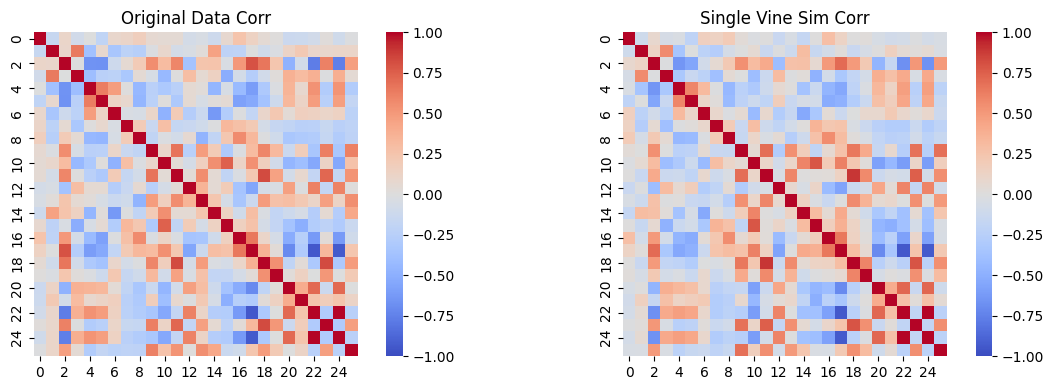


--- Mixture(2) KS Test Results ---
 Feature 0, KS-Stat=0.0104, p-value=0.8919
 Feature 1, KS-Stat=0.0119, p-value=0.7773
 Feature 2, KS-Stat=0.0116, p-value=0.8053
 Feature 3, KS-Stat=0.0114, p-value=0.8188
 Feature 4, KS-Stat=0.0057, p-value=1.0000
 Feature 5, KS-Stat=0.0093, p-value=0.9536
 Feature 6, KS-Stat=0.0122, p-value=0.7483
 Feature 7, KS-Stat=0.0091, p-value=0.9601
 Feature 8, KS-Stat=0.0072, p-value=0.9974
 Feature 9, KS-Stat=0.0096, p-value=0.9389
 Feature 10, KS-Stat=0.0096, p-value=0.9389
 Feature 11, KS-Stat=0.0093, p-value=0.9536
 Feature 12, KS-Stat=0.0072, p-value=0.9974
 Feature 13, KS-Stat=0.0135, p-value=0.6276
 Feature 14, KS-Stat=0.0046, p-value=1.0000
 Feature 15, KS-Stat=0.0108, p-value=0.8693
 Feature 16, KS-Stat=0.0126, p-value=0.7186
 Feature 17, KS-Stat=0.0085, p-value=0.9801
 Feature 18, KS-Stat=0.0119, p-value=0.7773
 Feature 19, KS-Stat=0.0109, p-value=0.8573
 Feature 20, KS-Stat=0.0096, p-value=0.9389
 Feature 21, KS-Stat=0.0075, p-value=0.9952
 Featu

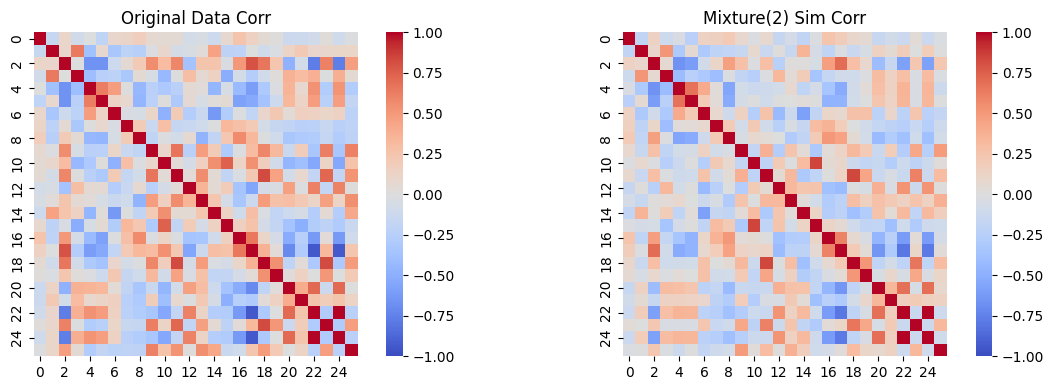

In [ ]:
import numpy as np
import random

class SyntheticAnomalyGenerator:
    def __init__(self,
                 window_size,
                 reference_anomalies,
                 anomaly_types=['local_perturbation']):
        """
        Initializes the anomaly generator that oversamples real anomaly data
        but applies small perturbations to create a local neighborhood around
        the real anomalies.

        Args:
            window_size (int): The size of the anomaly window to inject.
            reference_anomalies (np.ndarray): Real anomaly data from which to oversample.
              Shape could be (num_anomalies, sequence_length, num_features) or
              (num_anomalies, num_features) if each row is a snippet, etc.
            anomaly_types (list): We keep it flexible, but default to ['local_perturbation'].
        """
        self.anomaly_types = anomaly_types
        self.window_size = window_size

        # Real anomaly data to oversample from
        self.reference_anomalies = reference_anomalies

    def inject_anomaly_into_sequence(self, sequence):
        """
        Called externally to inject an anomaly into 'sequence' by
        picking a real anomaly snippet, perturbing it, and overlaying.
        """
        anomalous_sequence = sequence.copy()
        anomaly_type = random.choice(self.anomaly_types)

        seq_length, num_features = anomalous_sequence.shape

        if seq_length <= self.window_size:
            t0 = 0
            t1 = seq_length
        else:
            t0 = random.randint(0, seq_length - self.window_size)
            t1 = t0 + self.window_size

        if anomaly_type == 'local_perturbation':
            anomalous_sequence = self.local_perturbation_injection(anomalous_sequence, t0, t1)
        elif anomaly_type == 'permutation_anomaly':
            # optional, if you want partial permutations
            anomalous_sequence = self.permutation_anomaly(anomalous_sequence, t0, t1)

        return anomalous_sequence

    def local_perturbation_injection(self, sequence, t0, t1):
        """
        1) Randomly pick a real anomaly snippet from reference_anomalies.
        2) Possibly adapt or clamp it to 'window_size'.
        3) Add small random perturbations (noise, slight scaling, partial permutations, etc.).
        4) Overlay onto 'sequence[t0:t1]'.
        """
        anomalous_sequence = sequence.copy()
        window_length = t1 - t0
        seq_length, num_features = anomalous_sequence.shape

        # 1) pick a random anomaly snippet from reference_anomalies
        #    Suppose reference_anomalies has shape (num_anomalies, anomaly_length, num_features)
        #    or (num_anomalies, num_features) if each row is a snippet.
        rand_idx = random.randint(0, self.reference_anomalies.shape[0]-1)
        real_anomaly_snippet = self.reference_anomalies[rand_idx]

        # Check if real_anomaly_snippet is 2D or 1D
        if real_anomaly_snippet.ndim == 1:
            # shape (num_features,) => we replicate or clamp it
            # e.g. we'll just tile it for 'window_length'
            real_anomaly_snippet = np.tile(real_anomaly_snippet, (window_length,1))
        elif real_anomaly_snippet.shape[0] != window_length:
            # We do a clamp or pad approach:
            real_len = real_anomaly_snippet.shape[0]
            if real_len > window_length:
                # clamp
                start_ = random.randint(0, real_len - window_length)
                real_anomaly_snippet = real_anomaly_snippet[start_:start_+window_length, :]
            else:
                # if real_len < window_length => pad repeats or edge
                repeats_needed = window_length - real_len
                # simplest => tile or pad
                real_anomaly_snippet = np.concatenate([
                    real_anomaly_snippet,
                    np.tile(real_anomaly_snippet[-1,:], (repeats_needed,1))
                ], axis=0)

        # Now real_anomaly_snippet is shape (window_length, num_features)

        # 2) Add small perturbations
        perturbed_snippet = self.apply_small_perturbations(real_anomaly_snippet)

        # 3) Overlay
        anomalous_sequence[t0:t1] = perturbed_snippet
        return anomalous_sequence

    def apply_small_perturbations(self, snippet):
        """
        snippet shape: (window_length, num_features)
        We'll do e.g.:
          - small gaussian noise
          - slight random scaling per feature
          - partial permutations of a few rows (rare)
        all to keep changes mild.
        """
        w_len, n_feats = snippet.shape
        snippet_ = snippet.copy()

        # A) small gaussian noise
        noise_std = 0.05 * np.std(snippet_)  # e.g. 5% of snippet's std
        noise = np.random.normal(0, noise_std, snippet_.shape)
        snippet_ += noise

        # B) slight random scaling per feature
        # e.g. each feature f => scale_f in [0.95,1.05]
        scales = 0.95 + 0.1*np.random.rand(n_feats)
        for f in range(n_feats):
            snippet_[:, f] *= scales[f]

        # C) partial row permutation, only a few rows
        # e.g. we permute 10% of the snippet rows:
        row_count = int(0.1 * w_len)  # 10% of rows
        if row_count>1:
            perm_indices = np.random.choice(w_len, size=row_count, replace=False)
            # shuffle those rows
            snippet_[perm_indices] = snippet_[np.random.permutation(perm_indices)]

        return snippet_

    def permutation_anomaly(self, sequence, t0, t1):
        """
        If you want a direct 'permutation_anomaly' approach:
        """
        anomalous_sequence = sequence.copy()
        window = anomalous_sequence[t0:t1]
        perm_indices = np.random.permutation(len(window))
        permuted_window = window[perm_indices]
        anomalous_sequence[t0:t1] = permuted_window
        return anomalous_sequence


In [ ]:
def extract_sequences(time_series_data, window_size, step_size):
    total_length, num_features = time_series_data.shape
    sequences = []

    for start_idx in range(0, total_length - window_size + 1, step_size):
        end_idx = start_idx + window_size
        sequence = time_series_data[start_idx:end_idx]
        sequences.append(sequence)

    return sequences

In [ ]:
def generate_consecutive_pairs(sequences, sequence_labels):
    """
    Generate pairs of consecutive sequences.

    Args:
        sequences (list): List of sequences.
        sequence_labels (list): Corresponding labels for each sequence.

    Returns:
        x1_pairs (list): List of sequences for x1.
        x2_pairs (list): List of sequences for x2.
        pair_labels (list): List of labels for each pair (0 for normal-normal, 1 for anomaly-involved).
    """
    x1_pairs = []
    x2_pairs = []
    pair_labels = []

    for i in range(len(sequences) - 1):
        x1 = sequences[i]
        x2 = sequences[i + 1]
        label = 0  # Default to normal-normal

        # If either sequence is anomalous, label the pair as anomaly-involved
        if sequence_labels[i] == 1 or sequence_labels[i + 1] == 1:
            label = 1

        x1_pairs.append(x1)
        x2_pairs.append(x2)
        pair_labels.append(label)

    return x1_pairs, x2_pairs, pair_labels


In [ ]:
def collate_fn(batch):
    x1_batch, x2_batch, labels = zip(*batch)

    x1_batch = [torch.tensor(x, dtype=torch.float32) for x in x1_batch]
    x2_batch = [torch.tensor(x, dtype=torch.float32) for x in x2_batch]

    x1_lengths = torch.tensor([seq.size(0) for seq in x1_batch], dtype=torch.long)
    x2_lengths = torch.tensor([seq.size(0) for seq in x2_batch], dtype=torch.long)

    padded_x1 = pad_sequence(x1_batch, batch_first=True, padding_value=0.0)
    padded_x2 = pad_sequence(x2_batch, batch_first=True, padding_value=0.0)

    labels = torch.tensor(labels, dtype=torch.float32)  # For contrastive loss, labels should be float

    max_len_x1 = padded_x1.size(1)
    max_len_x2 = padded_x2.size(1)

    range_x1 = torch.arange(max_len_x1).unsqueeze(0).expand(len(x1_lengths), max_len_x1)
    range_x2 = torch.arange(max_len_x2).unsqueeze(0).expand(len(x2_lengths), max_len_x2)

    x1_mask = (range_x1 >= x1_lengths.unsqueeze(1)).to(torch.bool)
    x2_mask = (range_x2 >= x2_lengths.unsqueeze(1)).to(torch.bool)

    return padded_x1, padded_x2, labels, x1_mask, x2_mask


NameError: name 'raw_data' is not defined

In [ ]:
def apply_synthetic_anomalies_to_sequences(sequences, anomaly_percentage, anomaly_generator):
    """
    Inject synthetic anomalies into a specified percentage of sequences.

    Args:
        sequences (list): List of sequences extracted from the time series data.
        anomaly_percentage (float): Percentage of sequences to inject anomalies (0.1 to 1.0).
        anomaly_generator (SyntheticAnomalyGenerator): An instance of the anomaly generator.

    Returns:
        augmented_sequences (list): List of sequences after injecting anomalies.
        sequence_labels (list): Labels for each sequence (0 for normal, 1 for anomaly).
    """
    num_sequences = len(sequences)
    num_anomalous_sequences = int(num_sequences * anomaly_percentage)
    anomaly_indices = set(random.sample(range(num_sequences), num_anomalous_sequences))

    augmented_sequences = []
    sequence_labels = []

    for i, seq in enumerate(sequences):
        if i in anomaly_indices:
            # Inject anomaly into the entire sequence
            augmented_seq = anomaly_generator.inject_anomaly_into_sequence(seq)
            augmented_sequences.append(augmented_seq)
            sequence_labels.append(1)
        else:
            # Normal sequence
            augmented_sequences.append(seq)
            sequence_labels.append(0)

    return augmented_sequences, sequence_labels


In [ ]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x1_pairs, x2_pairs, pair_labels, transform=None):
        assert len(x1_pairs) == len(x2_pairs) == len(pair_labels), "All inputs must have the same length."
        self.x1_pairs = x1_pairs
        self.x2_pairs = x2_pairs
        self.pair_labels = pair_labels
        self.transform = transform

    def __len__(self):
        return len(self.pair_labels)

    def __getitem__(self, idx):
        x1 = self.x1_pairs[idx]
        x2 = self.x2_pairs[idx]
        label = self.pair_labels[idx]

        if self.transform:
            x1 = self.transform(x1)
            x2 = self.transform(x2)

        return x1, x2, label


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.output_proj = nn.Linear(model_dim, model_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask=None):
        x = self.input_proj(x)  # (batch_size, seq_length, model_dim)
        x = self.dropout(x)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)  # (batch_size, seq_length, model_dim)

        if src_key_padding_mask is not None:
            # Create data mask: True where data is present
            data_mask = (~src_key_padding_mask).unsqueeze(2).type_as(x)  # (batch_size, seq_length, 1)
            x = x * data_mask  # Zero out padding positions: (batch_size, seq_length, model_dim)
            x_sum = x.sum(dim=1)  # Sum over seq_length: (batch_size, model_dim)

            lengths = data_mask.sum(dim=1)  # Sum over seq_length: (batch_size, 1)
            lengths = lengths.clamp(min=1)  # Avoid division by zero
            x = x_sum / lengths  # (batch_size, model_dim)
        else:
            x = x.mean(dim=1)  # Average over seq_length: (batch_size, model_dim)

        x = self.output_proj(x)  # (batch_size, model_dim)
        x = self.activation(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.distributions import MultivariateNormal
from torch.special import gammaln

def _multivariate_student_t_logpdf(x, L, nu):
    """
    Computes the log density of a multivariate Student-t distribution at point x.

    x:  (batch_size, d)
    L:  (d, d) lower-triangular Cholesky factor of correlation matrix Sigma => Sigma = L L^T
    nu: scalar degrees of freedom

    Returns: (batch_size,) log density under T_{nu, Sigma}.
    """
    eps = 1e-12
    batch_size, d = x.shape

    # 1) precision = (L L^T)^{-1} => we can do cholesky_inverse(L)
    #    sigma = L @ L^T, so sigma^{-1} = (L^{-1})^T (L^{-1})
    Sigma_inv = torch.cholesky_inverse(L)

    # 2) log|Sigma| => 2 * sum(log(diag(L)))
    log_det_Sigma = 2.0 * torch.log(torch.diagonal(L, 0)).sum()

    # 3) Quadratic form => x^T Sigma^{-1} x
    quadform = torch.einsum('bi,ij,bj->b', x, Sigma_inv, x)  # shape (batch_size,)

    # 4) Student-t logpdf formula:
    #    log f_{t_{nu,Sigma}}(x)
    #  =  Gamma((nu+d)/2) - Gamma(nu/2)
    #     - 0.5 log|Sigma|
    #     - d/2 log(nu pi)
    #     - (nu+d)/2 log(1 + (1/nu)*x^T Sigma^{-1} x)
    d = float(d)
    nu_ = nu + eps  # ensure positivity
    c1 = (gammaln(0.5*(nu_ + d)) - gammaln(0.5*nu_))
    c2 = -0.5*log_det_Sigma
    c3 = -0.5*d*(math.log(math.pi*nu_+eps))

    # final
    logprob = c1 + c2 + c3 - 0.5*(nu_ + d)*torch.log1p(quadform/(nu_+eps))
    return logprob

class StudentTCopula_Normal(nn.Module):
    """
    A Student-t Copula capturing heavy-tailed dependence in the latent space.
    Similar logic to the GaussianCopula, but we do:
      1) standardize z
      2) transform z => U in (0,1) via Tcdf
      3) transform U => z_trans via Ticdf
      4) build correlation matrix from L (cholesky factor)
      5) Evaluate multivariate T log-likelihood
    """
    def __init__(self, latent_dim):
        super(StudentTCopula_Normal, self).__init__()
        self.latent_dim = latent_dim

        # Cholesky factor for correlation
        n_tril_elements = (latent_dim * (latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements)*0.1)

        # degrees of freedom param
        # we do softplus for positivity
        self.nu_param = nn.Parameter(torch.tensor(5.0))

    def forward(self, z, mu=None, std=None):
        """
        z: (batch_size, latent_dim)
        mu, std: optional mean/std for standardizing z. If None, we compute from z.
        returns: (batch_size,) log-likelihood under the Student-t copula
        """
        device = z.device
        eps = 1e-6
        batch_size, d = z.shape

        # 1) standardize z
        if mu is None or std is None:
            mu_ = z.mean(dim=0, keepdim=True)
            std_ = z.std(dim=0, keepdim=True, unbiased=False)+eps
        else:
            mu_ = mu.to(device)
            std_ = std.to(device)
            # ensure positivity
            std_ = torch.where(std_>0, std_, eps*torch.ones_like(std_))

        z_standard = (z - mu_) / std_
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # 2) transform to U in (0,1) via Student T cdf
        # PyTorch doesn't have direct Tcdf or Ticdf, so we might rely on SciPy or custom approach
        # For demonstration, let's do a small function that calls scipy t.cdf or t.ppf
        # We'll define a helper below or approximate. We'll do a "detach().cpu().numpy()" approach.

        u = _student_t_cdf(z_standard, self._nu_value().item())
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # 3) transform U => z_trans via T icdf
        z_trans = _student_t_ppf(u, self._nu_value().item())

        # 4) build correlation from L_params
        L = torch.zeros(d, d, device=device)
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # ensure positive diagonal
        diag_idx = torch.arange(d, device=device)
        diag_vals = torch.diagonal(L).clone()
        diag_vals = F.softplus(diag_vals) + eps
        L[diag_idx, diag_idx] = diag_vals

        # 5) Evaluate multivariate T logpdf
        nu_ = self._nu_value()
        log_prob = _multivariate_student_t_logpdf(z_trans, L, nu_)

        return log_prob

    def _nu_value(self):
        """
        Return positive degrees of freedom.
        We add a small eps to ensure positivity.
        """
        return F.softplus(self.nu_param)+1e-4

def _student_t_cdf(z, nu):
    """
    Compute univariate student-t cdf for each entry in z, do it elementwise.
    We'll call SciPy if available. Otherwise, a placeholder approach.
    Because we need z => shape (batch, dim).
    We'll do a detach to CPU, compute via scipy, then back to torch.
    This breaks gradient, but for typical copula-based anomaly detection,
    we only backprop through correlation params, not the entire cdf.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    z_np = z.detach().cpu().numpy()
    u_np = scipy_t.cdf(z_np, df=nu)
    return torch.tensor(u_np, device=z.device, dtype=z.dtype)

def _student_t_ppf(u, nu):
    """
    Inverse of the cdf for Student-t (ppf).
    We'll do the same approach with SciPy.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    u_np = u.detach().cpu().numpy()
    z_np = scipy_t.ppf(u_np, df=nu)
    return torch.tensor(z_np, device=u.device, dtype=u.dtype)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.distributions import MultivariateNormal
from torch.special import gammaln

def _multivariate_student_t_logpdf(x, L, nu):
    """
    Computes the log density of a multivariate Student-t distribution at point x.

    x:  (batch_size, d)
    L:  (d, d) lower-triangular Cholesky factor of correlation matrix Sigma => Sigma = L L^T
    nu: scalar degrees of freedom

    Returns: (batch_size,) log density under T_{nu, Sigma}.
    """
    eps = 1e-12
    batch_size, d = x.shape

    # 1) precision = (L L^T)^{-1} => we can do cholesky_inverse(L)
    #    sigma = L @ L^T, so sigma^{-1} = (L^{-1})^T (L^{-1})
    Sigma_inv = torch.cholesky_inverse(L)

    # 2) log|Sigma| => 2 * sum(log(diag(L)))
    log_det_Sigma = 2.0 * torch.log(torch.diagonal(L, 0)).sum()

    # 3) Quadratic form => x^T Sigma^{-1} x
    quadform = torch.einsum('bi,ij,bj->b', x, Sigma_inv, x)  # shape (batch_size,)

    # 4) Student-t logpdf formula:
    #    log f_{t_{nu,Sigma}}(x)
    #  =  Gamma((nu+d)/2) - Gamma(nu/2)
    #     - 0.5 log|Sigma|
    #     - d/2 log(nu pi)
    #     - (nu+d)/2 log(1 + (1/nu)*x^T Sigma^{-1} x)
    d = float(d)
    nu_ = nu + eps  # ensure positivity
    c1 = (gammaln(0.5*(nu_ + d)) - gammaln(0.5*nu_))
    c2 = -0.5*log_det_Sigma
    c3 = -0.5*d*(math.log(math.pi*nu_+eps))

    # final
    logprob = c1 + c2 + c3 - 0.5*(nu_ + d)*torch.log1p(quadform/(nu_+eps))
    return logprob

class StudentTCopula_Anomaly(nn.Module):
    """
    A Student-t Copula capturing heavy-tailed dependence in the latent space.
    Similar logic to the GaussianCopula, but we do:
      1) standardize z
      2) transform z => U in (0,1) via Tcdf
      3) transform U => z_trans via Ticdf
      4) build correlation matrix from L (cholesky factor)
      5) Evaluate multivariate T log-likelihood
    """
    def __init__(self, latent_dim):
        super(StudentTCopula_Anomaly, self).__init__()
        self.latent_dim = latent_dim

        # Cholesky factor for correlation
        n_tril_elements = (latent_dim * (latent_dim + 1)) // 2
        self.L_params = nn.Parameter(torch.randn(n_tril_elements)*0.1)

        # degrees of freedom param
        # we do softplus for positivity
        self.nu_param = nn.Parameter(torch.tensor(5.0))

    def forward(self, z, mu=None, std=None):
        """
        z: (batch_size, latent_dim)
        mu, std: optional mean/std for standardizing z. If None, we compute from z.
        returns: (batch_size,) log-likelihood under the Student-t copula
        """
        device = z.device
        eps = 1e-6
        batch_size, d = z.shape

        # 1) standardize z
        if mu is None or std is None:
            mu_ = z.mean(dim=0, keepdim=True)
            std_ = z.std(dim=0, keepdim=True, unbiased=False)+eps
        else:
            mu_ = mu.to(device)
            std_ = std.to(device)
            # ensure positivity
            std_ = torch.where(std_>0, std_, eps*torch.ones_like(std_))

        z_standard = (z - mu_) / std_
        z_standard = torch.clamp(z_standard, min=-10.0, max=10.0)

        # 2) transform to U in (0,1) via Student T cdf
        # PyTorch doesn't have direct Tcdf or Ticdf, so we might rely on SciPy or custom approach
        # For demonstration, let's do a small function that calls scipy t.cdf or t.ppf
        # We'll define a helper below or approximate. We'll do a "detach().cpu().numpy()" approach.

        u = _student_t_cdf(z_standard, self._nu_value().item())
        u = torch.clamp(u, min=eps, max=1.0 - eps)

        # 3) transform U => z_trans via T icdf
        z_trans = _student_t_ppf(u, self._nu_value().item())

        # 4) build correlation from L_params
        L = torch.zeros(d, d, device=device)
        tril_indices = torch.tril_indices(row=d, col=d, offset=0)
        L[tril_indices[0], tril_indices[1]] = self.L_params

        # ensure positive diagonal
        diag_idx = torch.arange(d, device=device)
        diag_vals = torch.diagonal(L).clone()
        diag_vals = F.softplus(diag_vals) + eps
        L[diag_idx, diag_idx] = diag_vals

        # 5) Evaluate multivariate T logpdf
        nu_ = self._nu_value()
        log_prob = _multivariate_student_t_logpdf(z_trans, L, nu_)

        return log_prob

    def _nu_value(self):
        """
        Return positive degrees of freedom.
        We add a small eps to ensure positivity.
        """
        return F.softplus(self.nu_param)+1e-4

def _student_t_cdf(z, nu):
    """
    Compute univariate student-t cdf for each entry in z, do it elementwise.
    We'll call SciPy if available. Otherwise, a placeholder approach.
    Because we need z => shape (batch, dim).
    We'll do a detach to CPU, compute via scipy, then back to torch.
    This breaks gradient, but for typical copula-based anomaly detection,
    we only backprop through correlation params, not the entire cdf.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    z_np = z.detach().cpu().numpy()
    u_np = scipy_t.cdf(z_np, df=nu)
    return torch.tensor(u_np, device=z.device, dtype=z.dtype)

def _student_t_ppf(u, nu):
    """
    Inverse of the cdf for Student-t (ppf).
    We'll do the same approach with SciPy.
    """
    import numpy as np
    from scipy.stats import t as scipy_t

    u_np = u.detach().cpu().numpy()
    z_np = scipy_t.ppf(u_np, df=nu)
    return torch.tensor(z_np, device=u.device, dtype=u.dtype)


In [ ]:
import torch.nn.functional as F

def contrastive_loss(ll_gaussian, ll_vine, pair_labels, alpha=0.5, base_margin= 0.0):
    """
      A contrastive loss for separating normal vs. anomaly log-likelihoods with a *dynamic* margin:

      1) Normal frames => maximize log-likelihood => loss = -LL_normal
      2) Anomaly frames => LL_anomaly <= (mean_normal_LL - base_offset) on a per-sample basis.

    Now we receive both Gaussian and Studen-t LL. We pick the appropriate LL based on the labels:
    - Normal pairs (label=0) -> Gaussian Copula LL
    - Anomaly pairs (label=1) -> Vine Copula LL
    """
    pair_labels = pair_labels.view(-1)
    # Select appropriate LL based on labels
    chosen_ll = torch.where(pair_labels == 0, ll_gaussian, ll_vine)

    normal_ll = chosen_ll[pair_labels == 0]
    anomaly_ll = chosen_ll[pair_labels == 1]
    #print (f"Normal LL: {normal_ll.mean()}")
    #print (f"Anomaly LL: {anomaly_ll.mean()}")

    if len(normal_ll) > 0:
        loss_normal = -normal_ll
        mean_normal_ll = normal_ll.mean()
    else:
        loss_normal = torch.tensor(0.0, device=chosen_ll.device)
        mean_normal_ll = torch.tensor(0.0, device=chosen_ll.device)

    # -----------------------
    # Anomaly portion
    # -----------------------
    # We'll define a *dynamic margin* for anomalies
    # margin_dyn = mean_normal_ll - base_offset
    # Then for each anomaly sample 'a', we want a <= margin_dyn => diff = a - margin_dyn => F.relu(diff)
    # If diff>0 => penalty
    if len(anomaly_ll) > 0:
        margin_dyn = mean_normal_ll - base_margin
        # shape (#anomalies,)
        diff = anomaly_ll - margin_dyn
        # sample-level margin
        loss_anomaly = alpha * F.relu(diff).mean()
    else:
        loss_anomaly = torch.tensor(0.0, device=device)

    total_loss = (1 - alpha) * loss_normal.mean() + loss_anomaly.mean()


      # Monitoring: Print average log-likelihoods for debugging
    if len(normal_ll) > 0:
        print(f"Contrastive Loss - Normal LL Mean: {loss_normal.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Normal Samples in Batch.")

    if len(anomaly_ll) > 0:
        print(f"Contrastive Loss - Anomalous LL Mean: {loss_anomaly.mean().item():.4f}")
    else:
        print("Contrastive Loss - No Anomalous Samples in Batch.")

    return total_loss

In [ ]:
class AnomalyTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout, embedding_dim=64):
        super(AnomalyTransformer, self).__init__()
        self.encoder = TransformerEncoder(input_dim, model_dim, num_heads, num_layers, dropout)

        # We now have two different copulas
        self.gaussian_copula = StudentTCopula_Normal(latent_dim=2 * model_dim)
        self.vine_copula = StudentTCopula_Anomaly(latent_dim=2 * model_dim)

        self.embedding_layer = nn.Linear(2 * model_dim, embedding_dim)

    def forward(self, x1, x2, mask1=None, mask2=None):
        z1 = self.encoder(x1, src_key_padding_mask=mask1)
        z2 = self.encoder(x2, src_key_padding_mask=mask2)
        z = torch.cat((z1, z2), dim=1)

        # Compute both Gaussian and Vine likelihoods
        ll_gaussian = self.gaussian_copula(z)
        ll_vine = self.vine_copula(z)
        return ll_gaussian, ll_vine

    def get_embeddings(self, x1, x2, mask1=None, mask2=None):
        # Instead of passing x1, x2 as (B, features),
        # we do x1 => (B, 1, features)
        if x1.dim() == 2:
            x1 = x1.unsqueeze(1)  # shape => (B,1,features)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(1)

        transformed_x1 = self.encoder(x1, src_key_padding_mask=mask1)
        transformed_x2 = self.encoder(x2, src_key_padding_mask=mask2)

        # Now each is likely shape (B, seq_len=1, model_dim) or (B, model_dim)
        # if the encoder does a mean over seq_len => shape (B, model_dim).
        # We need to confirm the final shape. If the encoder returns 3D => e.g. (B,1,model_dim),
        # we might want to reduce it to 2D => (B,model_dim) by mean over dim=1.
        if transformed_x1.dim() == 3:
            # e.g. if shape => (B,1,hidden_dim), reduce to (B, hidden_dim)
            transformed_x1 = transformed_x1.mean(dim=1)
        if transformed_x2.dim() == 3:
            transformed_x2 = transformed_x2.mean(dim=1)

        # Now each => (B, hidden_dim)
        combined = torch.cat((transformed_x1, transformed_x2), dim=1)  # => (B,2*hidden_dim)
        embeddings = self.embedding_layer(combined)  # => (B, embed_dim)
        return embeddings

In [ ]:
#

In [ ]:
window_size = 100
step_size = 50  # Non-overlapping sequences
anomaly_percentage = 0.7 # 20% of sequences will be anomalous
batch_size = 64


# Step 1: Extract sequences from the raw data
sequences = extract_sequences(df_normal, window_size=window_size, step_size=step_size)
print(f"Total extracted sequences: {len(sequences)}")


anomaly_generator = SyntheticAnomalyGenerator(
    window_size=50,
    reference_anomalies=df_anomaly,
    anomaly_types=['local_perturbation']  # can add 'permutation_anomaly' if desired
)

# Step 2: Inject anomalies into sequences
augmented_sequences, sequence_labels = apply_synthetic_anomalies_to_sequences(
    sequences,
    anomaly_percentage=anomaly_percentage,
    anomaly_generator=anomaly_generator
)
print(f"Total anomalous sequences: {sum(sequence_labels)}")

# Step 3: Generate consecutive pairs
x1_pairs, x2_pairs, pair_labels = generate_consecutive_pairs(augmented_sequences, sequence_labels)
print(f"Total generated pairs: {len(pair_labels)}")
print(f"Anomaly-involved pairs: {sum(pair_labels)}")
print(f"Normal-normal pairs: {len(pair_labels) - sum(pair_labels)}")


Total extracted sequences: 1876
Total anomalous sequences: 1313
Total generated pairs: 1875
Anomaly-involved pairs: 1695
Normal-normal pairs: 180


In [ ]:
from torch.utils.data import DataLoader, Subset
import torch

# 1) Train dataset from x1_pairs, x2_pairs, pair_labels
train_dataset = TimeSeriesDataset(
    x1_pairs=x1_pairs,
    x2_pairs=x2_pairs,
    pair_labels=pair_labels,
    transform=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 2) Build a new dataset for the separate test data
import pandas as pd
data_norm_anom = pd.read_csv('/content/gdrive/MyDrive/DATASETS/TIME_SERIES_MULTI_V_DATA/SWAT_NORMALIZED.csv')
data_norm_anom = data_norm_anom.dropna()

data_test = data_norm_anom.iloc[100000:200000]
test_features = data_test.iloc[:, :-1].values
test_labels   = data_test.iloc[:,  -1].values
print (test_features.shape, test_labels.shape)

(100000, 26) (100000,)


In [ ]:
# Define a simple dataset
class SimpleTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels   = labels
        self.transform= transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

test_dataset_all = SimpleTimeSeriesDataset(test_features, test_labels)

In [ ]:
# 3) Split that dataset into val + test
test_dataset_size = len(test_dataset_all)
val_size = test_dataset_size // 2
val_indices = list(range(val_size))
test_indices= list(range(val_size, test_dataset_size))

val_subset  = torch.utils.data.Subset(test_dataset_all, val_indices)
test_subset = torch.utils.data.Subset(test_dataset_all, test_indices)

val_loader = DataLoader(
    val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    test_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = df_normal.shape[1]  # Number of features in the input data
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.3

model = AnomalyTransformer(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


**PLOTTING AND STATS**


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import torch

# Function to calculate F1_PA
def calculate_f1_pa(labels, preds):
    true_segments = []
    pred_segments = []

    # Get segments for true labels
    i = 0
    while i < len(labels):
        if labels[i] == 1:
            start = i
            while i < len(labels) and labels[i] == 1:
                i += 1
            true_segments.append((start, i - 1))
        i += 1

    # Get segments for predictions
    i = 0
    while i < len(preds):
        if preds[i] == 1:
            start = i
            while i < len(preds) and preds[i] == 1:
                i += 1
            pred_segments.append((start, i - 1))
        i += 1

    # Compute overlap
    tp = 0
    for t_start, t_end in true_segments:
        for p_start, p_end in pred_segments:
            if not (p_end < t_start or p_start > t_end):
                tp += 1
                break

    precision_pa = tp / len(pred_segments) if len(pred_segments) > 0 else 0
    recall_pa = tp / len(true_segments) if len(true_segments) > 0 else 0
    f1_pa = 2 * precision_pa * recall_pa / (precision_pa + recall_pa) if precision_pa + recall_pa > 0 else 0

    return f1_pa


# Validation Function
def validate(model, val_loader, device, threshold=None):
    model.eval()
    all_log_likelihoods = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # Check how many items are in the batch
            if len(batch) == 5:
                # The original multi-input scenario
                padded_x1, padded_x2, labels, x1_mask, x2_mask = batch
                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                labels = labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            if len(batch) == 3:
                padded_x1, padded_x2, labels = batch
                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                labels    = labels.to(device)

                ll_gaussian, ll_vine = model(padded_x1, padded_x2)

            elif len(batch) == 2:
                features, labels = batch
                features = features.to(device, dtype=torch.float32)
                labels = labels.to(device)

                # Unsqueeze so shape => (B, 1, num_features)
                features = features.unsqueeze(1)

                ll_gaussian, ll_vine = model(features, features)

            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Now we have (ll_gaussian, ll_vine) and 'labels'
            # Select final LL:  normal => Gaussian, anomaly => Vine
            ll_final = torch.where(labels == 0, ll_gaussian, ll_vine)

            all_log_likelihoods.extend(ll_final.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to np.array
    all_log_likelihoods = np.array(all_log_likelihoods)
    all_labels = np.array(all_labels)

    # If no threshold provided, find best by F1
    if threshold is None:
        best_f1 = 0.0
        best_threshold = 0.0
        mins, maxs = all_log_likelihoods.min(), all_log_likelihoods.max()
        for thresh in np.linspace(mins, maxs, 100):
            preds = (all_log_likelihoods < thresh).astype(int)
            f1 = f1_score(all_labels, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh
        threshold = best_threshold

    # Generate final predictions using threshold
    preds = (all_log_likelihoods < threshold).astype(int)

    accuracy = accuracy_score(all_labels, preds)
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds, zero_division=0)
    auc_roc = roc_auc_score(all_labels, -all_log_likelihoods)  # negative => lower LL => anomaly

    # Calculate F1_PA
    f1_pa = calculate_f1_pa(all_labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc_roc,
        'f1_pa': f1_pa,
        'threshold': threshold
    }


In [ ]:
def plot_log_likelihoods(model, loader, device, dataset_name="Dataset"):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from torch import no_grad

    model.eval()
    log_likelihoods = []
    labels = []

    normal_log_likelihoods = []
    anomaly_log_likelihoods = []

    with no_grad():
        for batch in loader:
            if len(batch) == 5:
                # old approach: (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device)
                padded_x2 = padded_x2.to(device)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # model returns (ll_gaussian, ll_vine)
                ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 2:
                # new approach: (features, labels)
                features, batch_labels = batch
                # shape => (batch_size, features) or (batch_size, seq_len, features)
                features = features.to(device, dtype=torch.float32)
                features = features.unsqueeze(1)  # => shape (B,1,features_dim)

                batch_labels = batch_labels.to(device)

                # If your model expects two inputs, we pass the same feature twice
                ll_gaussian, ll_vine = model(features, features)
            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Now we have ll_gaussian, ll_vine, and batch_labels
            # Normal => label=0 => use ll_gaussian
            # Anomaly=> label=1 => use ll_vine
            selected_ll = torch.where(batch_labels == 0, ll_gaussian, ll_vine)

            # Convert to CPU/NumPy
            selected_ll_np = selected_ll.cpu().numpy()
            labels_np = batch_labels.cpu().numpy()

            # Separate normal vs. anomaly for debugging
            normal_mask = (labels_np == 0)
            anomaly_mask= (labels_np == 1)

            normal_ll  = selected_ll_np[normal_mask]
            anomaly_ll = selected_ll_np[anomaly_mask]

            if len(normal_ll) > 0:
                normal_log_likelihoods.extend(normal_ll)
            if len(anomaly_ll) > 0:
                anomaly_log_likelihoods.extend(anomaly_ll)

            log_likelihoods.extend(selected_ll_np)
            labels.extend(labels_np)

    log_likelihoods = np.array(log_likelihoods)
    labels = np.array(labels)

    # Build a DataFrame for plotting
    import pandas as pd
    df = pd.DataFrame({
        'Log-Likelihood': log_likelihoods,
        'Label': ['Anomaly' if lb == 1 else 'Normal' for lb in labels]
    })

    # Summary stats
    if len(normal_log_likelihoods) > 0:
        mean_normal = np.mean(normal_log_likelihoods)
    else:
        mean_normal = float('nan')

    if len(anomaly_log_likelihoods) > 0:
        mean_anomaly = np.mean(anomaly_log_likelihoods)
    else:
        mean_anomaly = float('nan')

    print(f"[{dataset_name}] Mean Normal Log-Likelihood: {mean_normal:.4f}")
    print(f"[{dataset_name}] Mean Anomaly Log-Likelihood: {mean_anomaly:.4f}")

    # Plot distributions via Seaborn
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='Log-Likelihood', hue='Label', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'Log-Likelihood Distribution for {dataset_name} Set')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 277.8024
Contrastive Loss - Anomalous LL Mean: 150.7753
Contrastive Loss - Normal LL Mean: 303.1689
Contrastive Loss - Anomalous LL Mean: 161.4060
Contrastive Loss - Normal LL Mean: 311.2074
Contrastive Loss - Anomalous LL Mean: 161.8553
Contrastive Loss - Normal LL Mean: 271.8073
Contrastive Loss - Anomalous LL Mean: 148.1058
Contrastive Loss - Normal LL Mean: 265.1925
Contrastive Loss - Anomalous LL Mean: 146.2411
Contrastive Loss - Normal LL Mean: 284.1392
Contrastive Loss - Anomalous LL Mean: 154.0656
Contrastive Loss - Normal LL Mean: 325.3005
Contrastive Loss - Anomalous LL Mean: 166.8997
Contrastive Loss - Normal LL Mean: 316.3352
Contrastive Loss - Anomalous LL Mean: 163.9796
Contrastive Loss - Normal LL Mean: 282.2783
Contrastive Loss - Anomalous LL Mean: 150.9860
Contrastive Loss - Normal LL Mean: 298.1078
Contrastive Loss - Anomalous LL Mean: 156.7564
Contrastive Loss - Normal LL Mean: 296.9091
Contrastive Loss - Anomalous LL Mean: 156.2982

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


[Train-Epoch1] Mean Normal Log-Likelihood: -278.3552
[Train-Epoch1] Mean Anomaly Log-Likelihood: -290.2005


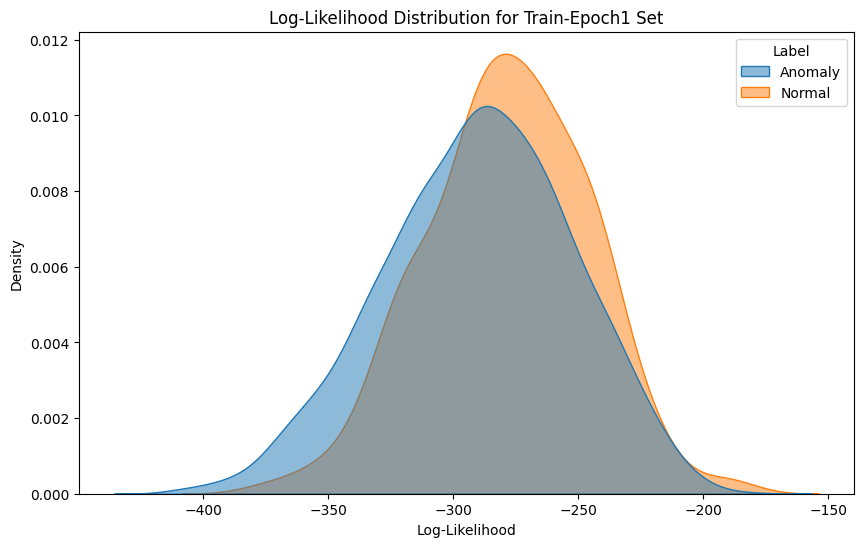

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch1] Mean Normal Log-Likelihood: -225.6909
[Val-Epoch1] Mean Anomaly Log-Likelihood: -232.0836


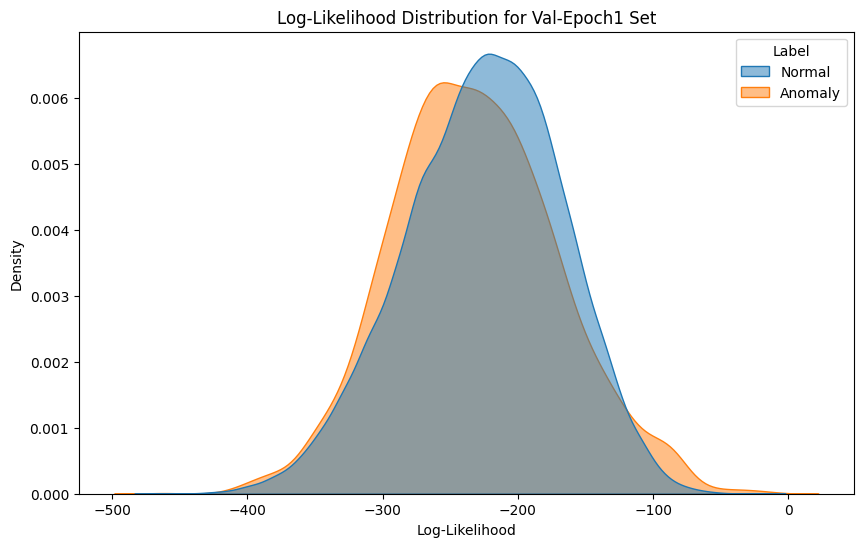

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 275.8157
Contrastive Loss - Anomalous LL Mean: 145.5644
Contrastive Loss - Normal LL Mean: 281.8567
Contrastive Loss - Anomalous LL Mean: 148.4776
Contrastive Loss - Normal LL Mean: 273.8384
Contrastive Loss - Anomalous LL Mean: 141.0164
Contrastive Loss - Normal LL Mean: 268.8636
Contrastive Loss - Anomalous LL Mean: 142.8970
Contrastive Loss - Normal LL Mean: 270.0311
Contrastive Loss - Anomalous LL Mean: 142.8200
Contrastive Loss - Normal LL Mean: 276.5388
Contrastive Loss - Anomalous LL Mean: 143.8286
Contrastive Loss - Normal LL Mean: 270.2400
Contrastive Loss - Anomalous LL Mean: 140.1787
Contrastive Loss - Normal LL Mean: 309.0158
Contrastive Loss - Anomalous LL Mean: 154.3049
Contrastive Loss - Normal LL Mean: 278.0347
Contrastive Loss - Anomalous LL Mean: 144.1648
Contrastive Loss - Normal LL Mean: 294.6482
Contrastive Loss - Anomalous LL Mean: 149.7145
Contrastive Loss - Normal LL Mean: 281.9222
Contrastive Loss - Anomalous LL Mean: 144.4367

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch2] Mean Normal Log-Likelihood: -270.2787
[Train-Epoch2] Mean Anomaly Log-Likelihood: -317.4970


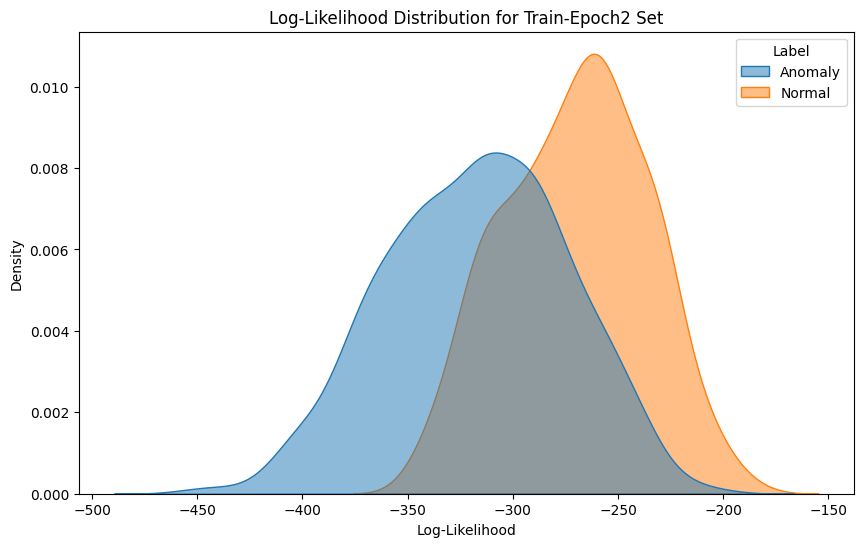

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch2] Mean Normal Log-Likelihood: -221.0261
[Val-Epoch2] Mean Anomaly Log-Likelihood: -247.6752


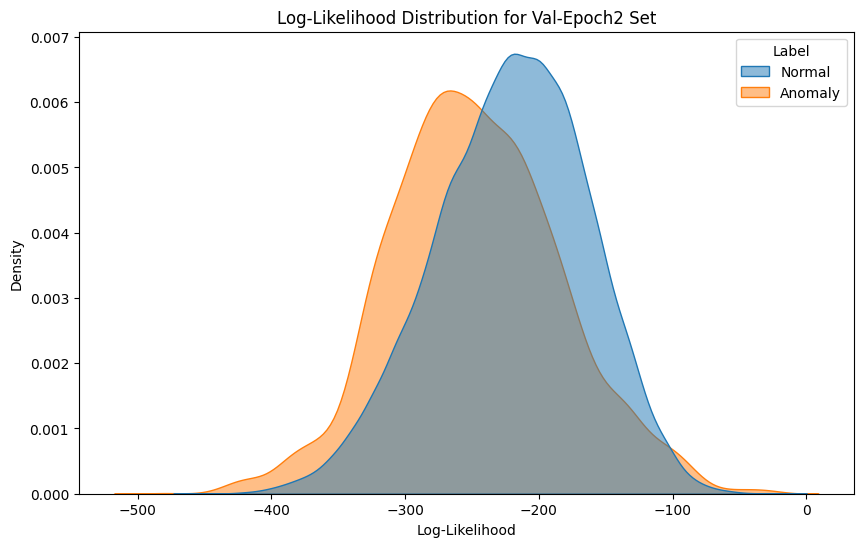

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 260.9247
Contrastive Loss - Anomalous LL Mean: 132.7599
Contrastive Loss - Normal LL Mean: 306.8514
Contrastive Loss - Anomalous LL Mean: 145.9687
Contrastive Loss - Normal LL Mean: 281.6705
Contrastive Loss - Anomalous LL Mean: 137.8204
Contrastive Loss - Normal LL Mean: 293.9397
Contrastive Loss - Anomalous LL Mean: 143.1479
Contrastive Loss - Normal LL Mean: 248.3995
Contrastive Loss - Anomalous LL Mean: 127.3379
Contrastive Loss - Normal LL Mean: 263.3827
Contrastive Loss - Anomalous LL Mean: 131.5210
Contrastive Loss - Normal LL Mean: 267.0344
Contrastive Loss - Anomalous LL Mean: 132.3087
Contrastive Loss - Normal LL Mean: 272.9375
Contrastive Loss - Anomalous LL Mean: 134.8313
Contrastive Loss - Normal LL Mean: 241.7357
Contrastive Loss - Anomalous LL Mean: 122.6312
Contrastive Loss - Normal LL Mean: 249.1404
Contrastive Loss - Anomalous LL Mean: 125.7018
Contrastive Loss - Normal LL Mean: 252.3659
Contrastive Loss - Anomalous LL Mean: 128.9630

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 260.3688
Contrastive Loss - Anomalous LL Mean: 120.7198
Contrastive Loss - Normal LL Mean: 261.0673
Contrastive Loss - Anomalous LL Mean: 120.9495
Contrastive Loss - Normal LL Mean: 255.1867
Contrastive Loss - Anomalous LL Mean: 119.9556
Contrastive Loss - Normal LL Mean: 263.8402
Contrastive Loss - Anomalous LL Mean: 120.6889
Contrastive Loss - Normal LL Mean: 266.1643
Contrastive Loss - Anomalous LL Mean: 121.8155
Contrastive Loss - Normal LL Mean: 285.4890
Contrastive Loss - Anomalous LL Mean: 126.0177
Contrastive Loss - Normal LL Mean: 276.7212
Contrastive Loss - Anomalous LL Mean: 125.3606
Contrastive Loss - Normal LL Mean: 283.5800
Contrastive Loss - Anomalous LL Mean: 122.3767
Contrastive Loss - Normal LL Mean: 267.4067
Contrastive Loss - Anomalous LL Mean: 119.3923
Contrastive Loss - Normal LL Mean: 247.7152
Contrastive Loss - Anomalous LL Mean: 107.0150
Contrastive Loss - Normal LL Mean: 228.5624
Contrastive Loss - Anomalous LL Mean: 107.5801

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch4] Mean Normal Log-Likelihood: -257.6786
[Train-Epoch4] Mean Anomaly Log-Likelihood: -417.7430


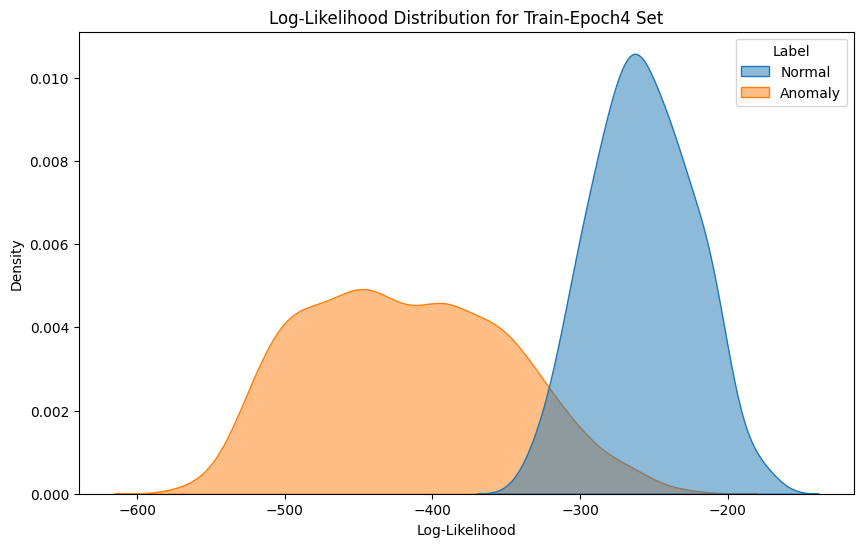

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch4] Mean Normal Log-Likelihood: -213.6482
[Val-Epoch4] Mean Anomaly Log-Likelihood: -313.1074


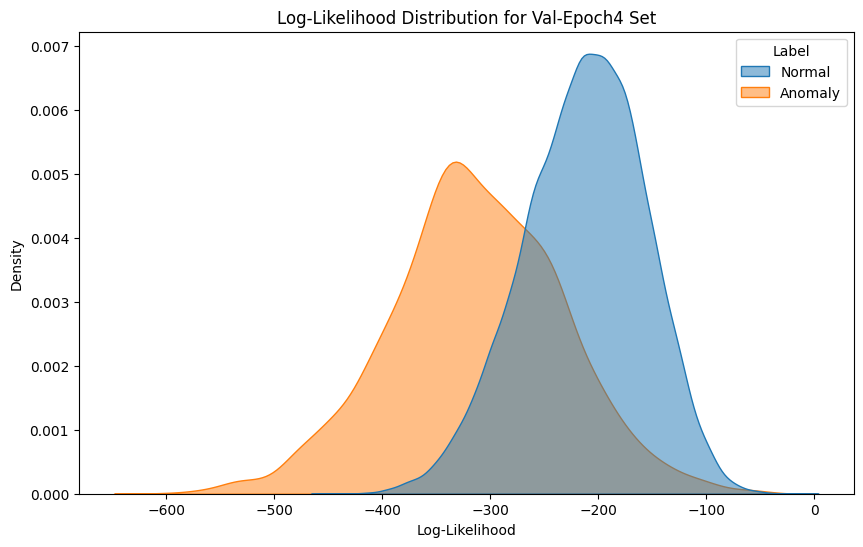

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 256.7804
Contrastive Loss - Anomalous LL Mean: 99.0163
Contrastive Loss - Normal LL Mean: 233.2462
Contrastive Loss - Anomalous LL Mean: 96.5095
Contrastive Loss - Normal LL Mean: 273.7672
Contrastive Loss - Anomalous LL Mean: 104.1980
Contrastive Loss - Normal LL Mean: 263.4592
Contrastive Loss - Anomalous LL Mean: 100.7300
Contrastive Loss - Normal LL Mean: 243.3074
Contrastive Loss - Anomalous LL Mean: 99.0119
Contrastive Loss - Normal LL Mean: 256.0815
Contrastive Loss - Anomalous LL Mean: 95.3101
Contrastive Loss - Normal LL Mean: 256.6640
Contrastive Loss - Anomalous LL Mean: 99.5248
Contrastive Loss - Normal LL Mean: 258.1766
Contrastive Loss - Anomalous LL Mean: 98.4775
Contrastive Loss - Normal LL Mean: 232.6917
Contrastive Loss - Anomalous LL Mean: 92.2847
Contrastive Loss - Normal LL Mean: 266.1125
Contrastive Loss - Anomalous LL Mean: 101.2401
Contrastive Loss - Normal LL Mean: 252.0249
Contrastive Loss - Anomalous LL Mean: 87.2646
Contras

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 207.1646
Contrastive Loss - Anomalous LL Mean: 69.6954
Contrastive Loss - Normal LL Mean: 265.0527
Contrastive Loss - Anomalous LL Mean: 80.9085
Contrastive Loss - Normal LL Mean: 253.7774
Contrastive Loss - Anomalous LL Mean: 73.9501
Contrastive Loss - Normal LL Mean: 262.3890
Contrastive Loss - Anomalous LL Mean: 81.9557
Contrastive Loss - Normal LL Mean: 253.9807
Contrastive Loss - Anomalous LL Mean: 74.4053
Contrastive Loss - Normal LL Mean: 266.9107
Contrastive Loss - Anomalous LL Mean: 79.0867
Contrastive Loss - Normal LL Mean: 241.8266
Contrastive Loss - Anomalous LL Mean: 66.9409
Contrastive Loss - Normal LL Mean: 291.7270
Contrastive Loss - Anomalous LL Mean: 83.1712
Contrastive Loss - Normal LL Mean: 235.4676
Contrastive Loss - Anomalous LL Mean: 67.4244
Contrastive Loss - Normal LL Mean: 248.2724
Contrastive Loss - Anomalous LL Mean: 75.9580
Contrastive Loss - Normal LL Mean: 256.2654
Contrastive Loss - Anomalous LL Mean: 74.6444
Contrastiv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch6] Mean Normal Log-Likelihood: -247.3089
[Train-Epoch6] Mean Anomaly Log-Likelihood: -577.0953


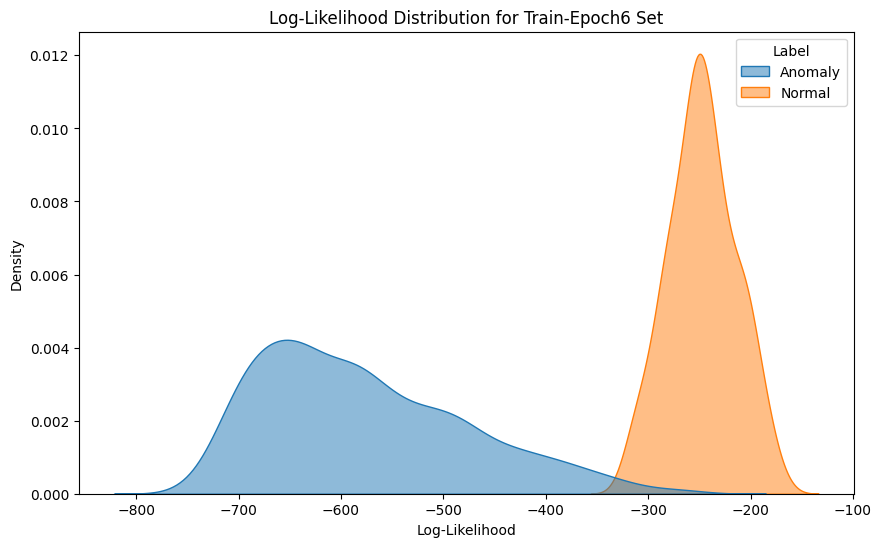

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch6] Mean Normal Log-Likelihood: -208.1174
[Val-Epoch6] Mean Anomaly Log-Likelihood: -451.9540


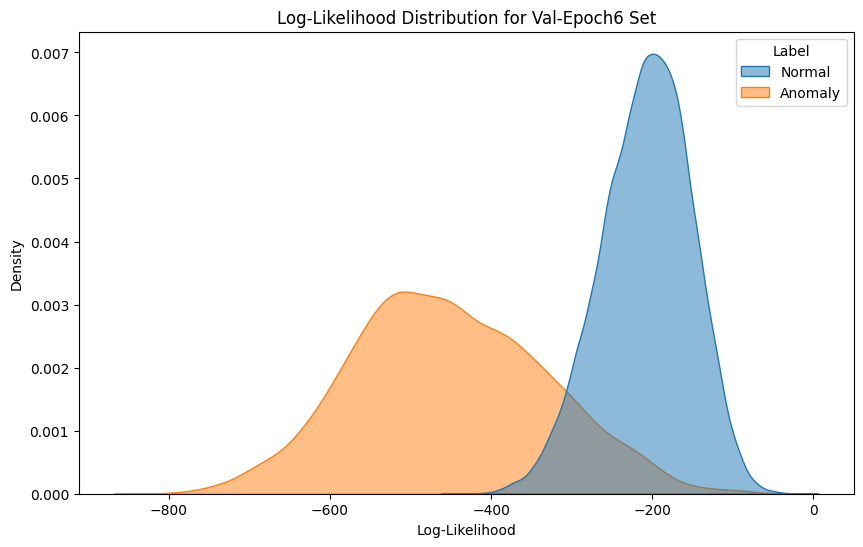

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 256.9330
Contrastive Loss - Anomalous LL Mean: 56.9577
Contrastive Loss - Normal LL Mean: 262.3133
Contrastive Loss - Anomalous LL Mean: 55.8319
Contrastive Loss - Normal LL Mean: 230.4864
Contrastive Loss - Anomalous LL Mean: 52.8145
Contrastive Loss - Normal LL Mean: 240.0636
Contrastive Loss - Anomalous LL Mean: 41.3424
Contrastive Loss - Normal LL Mean: 260.4728
Contrastive Loss - Anomalous LL Mean: 52.0889
Contrastive Loss - Normal LL Mean: 244.8130
Contrastive Loss - Anomalous LL Mean: 45.7471
Contrastive Loss - Normal LL Mean: 249.6089
Contrastive Loss - Anomalous LL Mean: 48.5112
Contrastive Loss - Normal LL Mean: 230.7179
Contrastive Loss - Anomalous LL Mean: 50.5386
Contrastive Loss - Normal LL Mean: 249.1015
Contrastive Loss - Anomalous LL Mean: 42.0948
Contrastive Loss - Normal LL Mean: 232.9316
Contrastive Loss - Anomalous LL Mean: 41.8363
Contrastive Loss - Normal LL Mean: 241.0357
Contrastive Loss - Anomalous LL Mean: 43.2308
Contrastiv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 239.8687
Contrastive Loss - Anomalous LL Mean: 26.7779
Contrastive Loss - Normal LL Mean: 232.3772
Contrastive Loss - Anomalous LL Mean: 23.6712
Contrastive Loss - Normal LL Mean: 243.8335
Contrastive Loss - Anomalous LL Mean: 25.9169
Contrastive Loss - Normal LL Mean: 256.1124
Contrastive Loss - Anomalous LL Mean: 30.2875
Contrastive Loss - Normal LL Mean: 244.5128
Contrastive Loss - Anomalous LL Mean: 17.5767
Contrastive Loss - Normal LL Mean: 252.8553
Contrastive Loss - Anomalous LL Mean: 30.7538
Contrastive Loss - Normal LL Mean: 249.1227
Contrastive Loss - Anomalous LL Mean: 15.6464
Contrastive Loss - Normal LL Mean: 233.3366
Contrastive Loss - Anomalous LL Mean: 22.6587
Contrastive Loss - Normal LL Mean: 248.0511
Contrastive Loss - Anomalous LL Mean: 26.0999
Contrastive Loss - Normal LL Mean: 225.6647
Contrastive Loss - Anomalous LL Mean: 17.4504
Contrastive Loss - Normal LL Mean: 259.2786
Contrastive Loss - Anomalous LL Mean: 31.2931
Contrastiv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch8] Mean Normal Log-Likelihood: -238.8118
[Train-Epoch8] Mean Anomaly Log-Likelihood: -731.2603


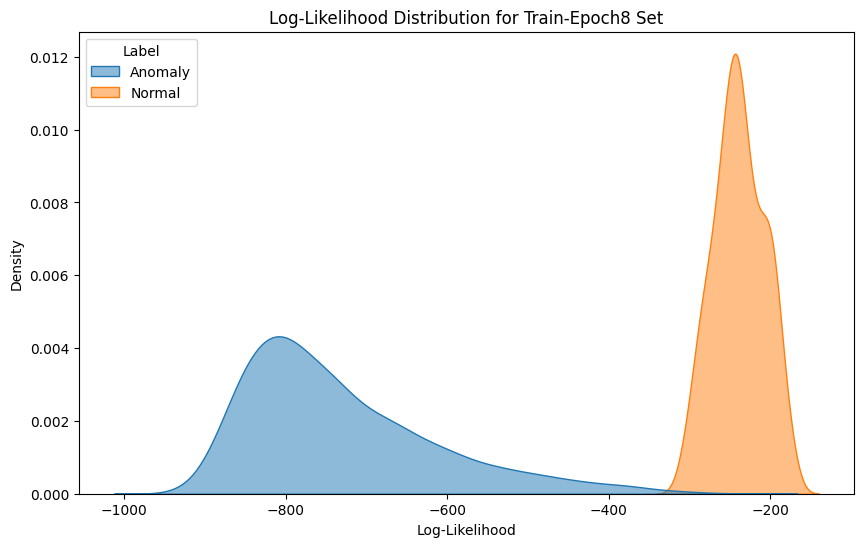

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch8] Mean Normal Log-Likelihood: -203.8586
[Val-Epoch8] Mean Anomaly Log-Likelihood: -607.6080


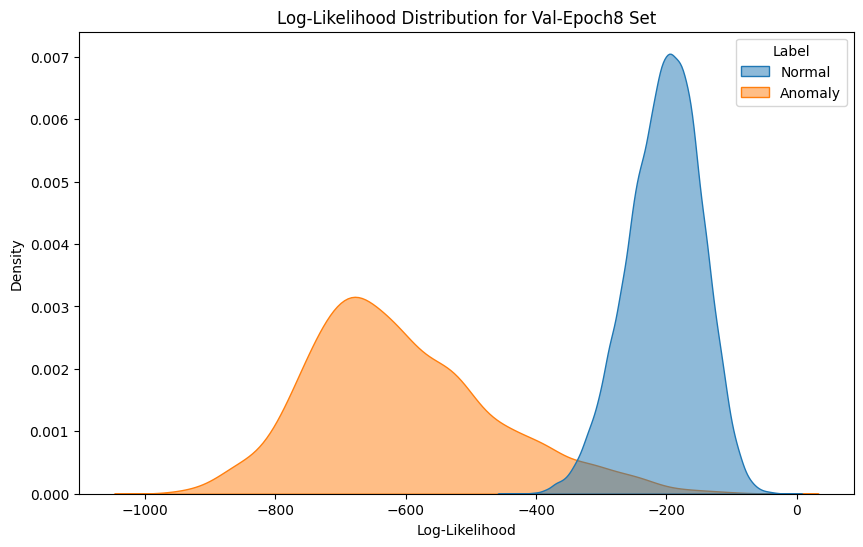

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 232.2408
Contrastive Loss - Anomalous LL Mean: 16.6511
Contrastive Loss - Normal LL Mean: 237.9907
Contrastive Loss - Anomalous LL Mean: 16.3549
Contrastive Loss - Normal LL Mean: 220.2660
Contrastive Loss - Anomalous LL Mean: 16.9320
Contrastive Loss - Normal LL Mean: 231.6753
Contrastive Loss - Anomalous LL Mean: 12.0442
Contrastive Loss - Normal LL Mean: 288.8858
Contrastive Loss - Anomalous LL Mean: 22.3786
Contrastive Loss - Normal LL Mean: 249.7326
Contrastive Loss - Anomalous LL Mean: 20.5487
Contrastive Loss - Normal LL Mean: 221.4941
Contrastive Loss - Anomalous LL Mean: 10.6646
Contrastive Loss - Normal LL Mean: 223.7258
Contrastive Loss - Anomalous LL Mean: 6.9692
Contrastive Loss - Normal LL Mean: 229.8836
Contrastive Loss - Anomalous LL Mean: 10.5593
Contrastive Loss - Normal LL Mean: 221.2697
Contrastive Loss - Anomalous LL Mean: 6.1222
Contrastive Loss - Normal LL Mean: 241.3222
Contrastive Loss - Anomalous LL Mean: 15.1218
Contrastive 

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 241.0966
Contrastive Loss - Anomalous LL Mean: 12.1652
Contrastive Loss - Normal LL Mean: 231.5789
Contrastive Loss - Anomalous LL Mean: 15.7666
Contrastive Loss - Normal LL Mean: 261.1542
Contrastive Loss - Anomalous LL Mean: 6.0814
Contrastive Loss - Normal LL Mean: 248.6425
Contrastive Loss - Anomalous LL Mean: 12.2318
Contrastive Loss - Normal LL Mean: 228.7571
Contrastive Loss - Anomalous LL Mean: 7.0735
Contrastive Loss - Normal LL Mean: 246.4759
Contrastive Loss - Anomalous LL Mean: 9.0781
Contrastive Loss - Normal LL Mean: 240.7863
Contrastive Loss - Anomalous LL Mean: 9.8866
Contrastive Loss - Normal LL Mean: 243.1075
Contrastive Loss - Anomalous LL Mean: 10.3444
Contrastive Loss - Normal LL Mean: 244.7914
Contrastive Loss - Anomalous LL Mean: 18.3459
Contrastive Loss - Normal LL Mean: 236.1938
Contrastive Loss - Anomalous LL Mean: 9.9886
Contrastive Loss - Normal LL Mean: 232.5591
Contrastive Loss - Anomalous LL Mean: 4.9385
Contrastive Loss

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch10] Mean Normal Log-Likelihood: -233.0165
[Train-Epoch10] Mean Anomaly Log-Likelihood: -808.0959


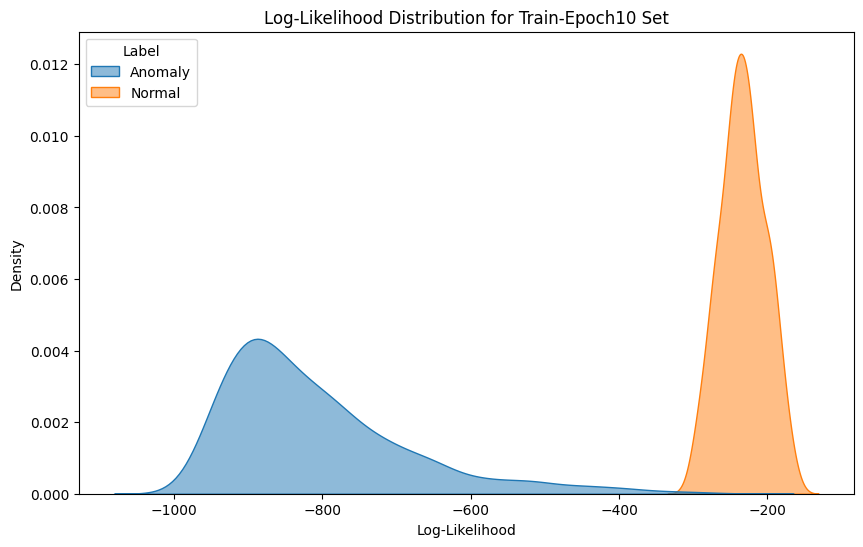

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch10] Mean Normal Log-Likelihood: -200.8207
[Val-Epoch10] Mean Anomaly Log-Likelihood: -685.9842


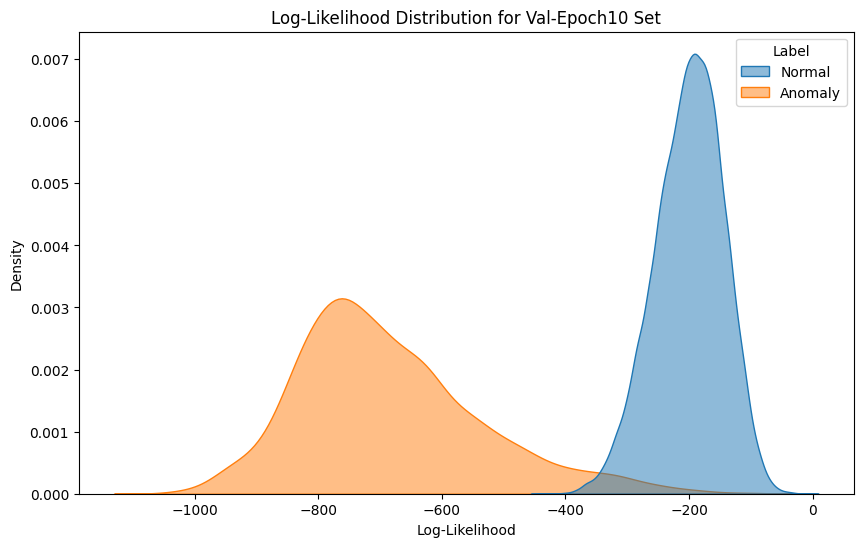

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 264.5325
Contrastive Loss - Anomalous LL Mean: 7.8395
Contrastive Loss - Normal LL Mean: 259.1922
Contrastive Loss - Anomalous LL Mean: 9.5052
Contrastive Loss - Normal LL Mean: 212.3835
Contrastive Loss - Anomalous LL Mean: 9.1370
Contrastive Loss - Normal LL Mean: 225.6887
Contrastive Loss - Anomalous LL Mean: 6.6482
Contrastive Loss - Normal LL Mean: 225.7204
Contrastive Loss - Anomalous LL Mean: 5.3337
Contrastive Loss - Normal LL Mean: 247.3627
Contrastive Loss - Anomalous LL Mean: 7.0560
Contrastive Loss - Normal LL Mean: 219.9981
Contrastive Loss - Anomalous LL Mean: 8.8678
Contrastive Loss - Normal LL Mean: 238.9109
Contrastive Loss - Anomalous LL Mean: 5.8182
Contrastive Loss - Normal LL Mean: 232.9854
Contrastive Loss - Anomalous LL Mean: 11.4042
Contrastive Loss - Normal LL Mean: 243.2459
Contrastive Loss - Anomalous LL Mean: 6.9989
Contrastive Loss - Normal LL Mean: 223.7511
Contrastive Loss - Anomalous LL Mean: 8.1446
Contrastive Loss - N

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 211.8481
Contrastive Loss - Anomalous LL Mean: 5.8153
Contrastive Loss - Normal LL Mean: 223.5323
Contrastive Loss - Anomalous LL Mean: 7.0986
Contrastive Loss - Normal LL Mean: 231.5666
Contrastive Loss - Anomalous LL Mean: 4.6136
Contrastive Loss - Normal LL Mean: 227.4499
Contrastive Loss - Anomalous LL Mean: 4.4228
Contrastive Loss - Normal LL Mean: 222.7977
Contrastive Loss - Anomalous LL Mean: 4.2013
Contrastive Loss - Normal LL Mean: 225.7959
Contrastive Loss - Anomalous LL Mean: 8.1218
Contrastive Loss - Normal LL Mean: 229.7663
Contrastive Loss - Anomalous LL Mean: 6.6239
Contrastive Loss - Normal LL Mean: 233.8718
Contrastive Loss - Anomalous LL Mean: 2.8917
Contrastive Loss - Normal LL Mean: 227.5861
Contrastive Loss - Anomalous LL Mean: 12.2944
Contrastive Loss - Normal LL Mean: 223.2587
Contrastive Loss - Anomalous LL Mean: 6.4663
Contrastive Loss - Normal LL Mean: 236.2267
Contrastive Loss - Anomalous LL Mean: 4.9096
Contrastive Loss - N

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch12] Mean Normal Log-Likelihood: -227.8265
[Train-Epoch12] Mean Anomaly Log-Likelihood: -852.9133


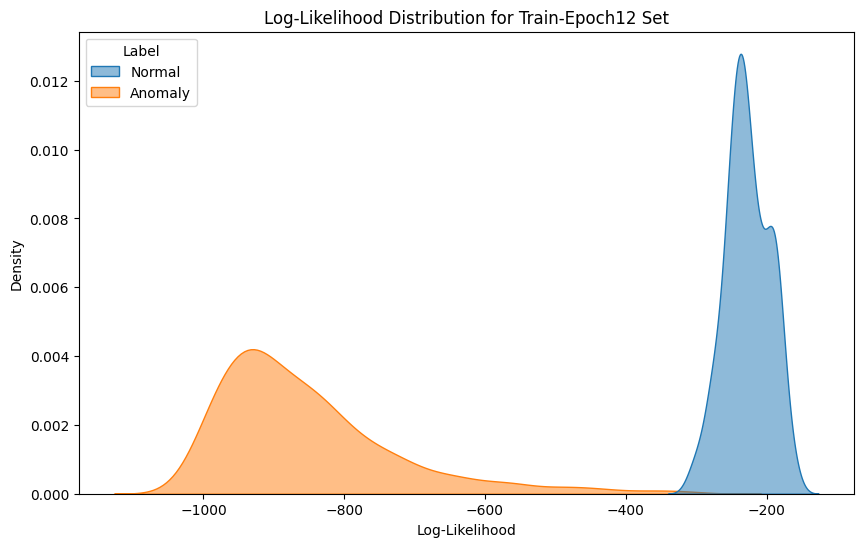

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch12] Mean Normal Log-Likelihood: -198.1747
[Val-Epoch12] Mean Anomaly Log-Likelihood: -731.3592


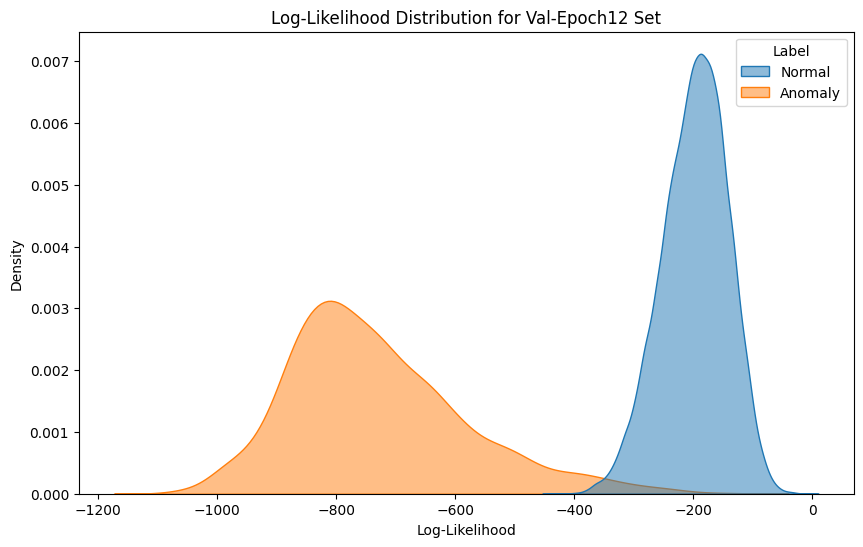

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 245.7153
Contrastive Loss - Anomalous LL Mean: 4.9286
Contrastive Loss - Normal LL Mean: 192.8502
Contrastive Loss - Anomalous LL Mean: 3.3036
Contrastive Loss - Normal LL Mean: 204.3220
Contrastive Loss - Anomalous LL Mean: 4.3026
Contrastive Loss - Normal LL Mean: 221.3544
Contrastive Loss - Anomalous LL Mean: 7.1484
Contrastive Loss - Normal LL Mean: 231.8291
Contrastive Loss - Anomalous LL Mean: 5.4663
Contrastive Loss - Normal LL Mean: 237.1217
Contrastive Loss - Anomalous LL Mean: 2.2037
Contrastive Loss - Normal LL Mean: 200.5723
Contrastive Loss - Anomalous LL Mean: 4.0330
Contrastive Loss - Normal LL Mean: 198.3310
Contrastive Loss - Anomalous LL Mean: 1.0303
Contrastive Loss - Normal LL Mean: 222.0321
Contrastive Loss - Anomalous LL Mean: 5.9757
Contrastive Loss - Normal LL Mean: 251.9351
Contrastive Loss - Anomalous LL Mean: 3.4953
Contrastive Loss - Normal LL Mean: 216.9116
Contrastive Loss - Anomalous LL Mean: 0.8166
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 229.5886
Contrastive Loss - Anomalous LL Mean: 1.4944
Contrastive Loss - Normal LL Mean: 216.8714
Contrastive Loss - Anomalous LL Mean: 6.1497
Contrastive Loss - Normal LL Mean: 221.3660
Contrastive Loss - Anomalous LL Mean: 2.1230
Contrastive Loss - Normal LL Mean: 230.3378
Contrastive Loss - Anomalous LL Mean: 2.4614
Contrastive Loss - Normal LL Mean: 221.8562
Contrastive Loss - Anomalous LL Mean: 3.3798
Contrastive Loss - Normal LL Mean: 254.5646
Contrastive Loss - Anomalous LL Mean: 7.4245
Contrastive Loss - Normal LL Mean: 198.9355
Contrastive Loss - Anomalous LL Mean: 2.2120
Contrastive Loss - Normal LL Mean: 204.2012
Contrastive Loss - Anomalous LL Mean: 3.6812
Contrastive Loss - Normal LL Mean: 220.9210
Contrastive Loss - Anomalous LL Mean: 6.1028
Contrastive Loss - Normal LL Mean: 210.5631
Contrastive Loss - Anomalous LL Mean: 4.9656
Contrastive Loss - Normal LL Mean: 235.0867
Contrastive Loss - Anomalous LL Mean: 4.3641
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch14] Mean Normal Log-Likelihood: -223.3476
[Train-Epoch14] Mean Anomaly Log-Likelihood: -889.7324


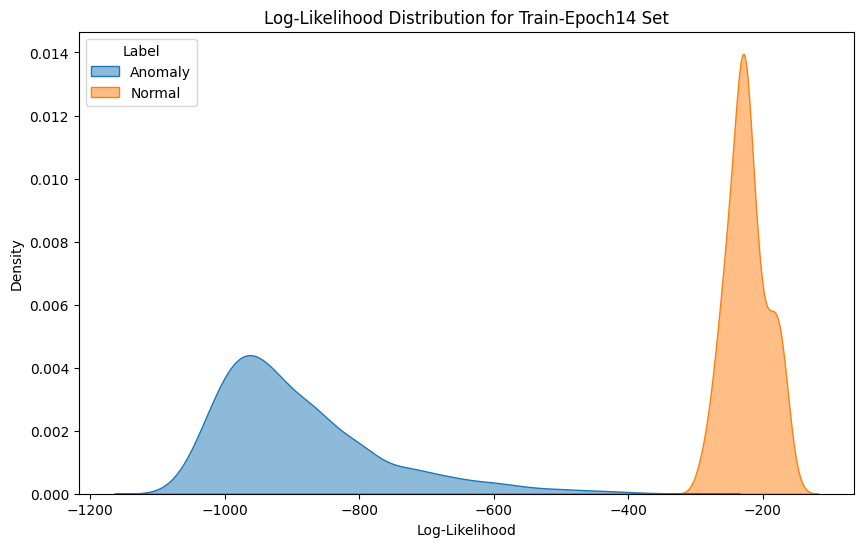

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch14] Mean Normal Log-Likelihood: -195.8981
[Val-Epoch14] Mean Anomaly Log-Likelihood: -764.5726


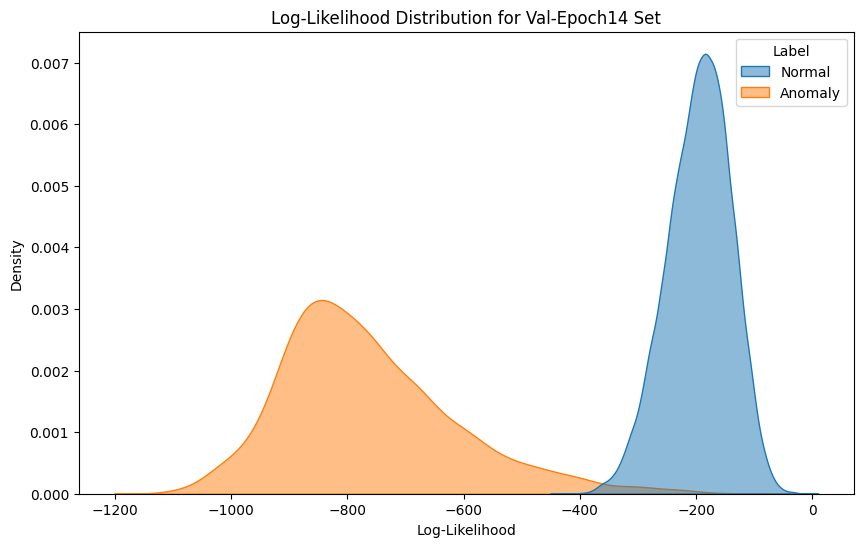

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 208.4127
Contrastive Loss - Anomalous LL Mean: 2.6635
Contrastive Loss - Normal LL Mean: 217.3615
Contrastive Loss - Anomalous LL Mean: 3.4354
Contrastive Loss - Normal LL Mean: 233.2318
Contrastive Loss - Anomalous LL Mean: 5.2700
Contrastive Loss - Normal LL Mean: 228.1783
Contrastive Loss - Anomalous LL Mean: 4.6899
Contrastive Loss - Normal LL Mean: 233.2125
Contrastive Loss - Anomalous LL Mean: 1.5336
Contrastive Loss - Normal LL Mean: 247.6943
Contrastive Loss - Anomalous LL Mean: 3.9120
Contrastive Loss - Normal LL Mean: 206.5793
Contrastive Loss - Anomalous LL Mean: 0.8289
Contrastive Loss - Normal LL Mean: 213.7422
Contrastive Loss - Anomalous LL Mean: 4.4050
Contrastive Loss - Normal LL Mean: 238.1366
Contrastive Loss - Anomalous LL Mean: 5.6833
Contrastive Loss - Normal LL Mean: 209.0278
Contrastive Loss - Anomalous LL Mean: 2.3419
Contrastive Loss - Normal LL Mean: 253.2220
Contrastive Loss - Anomalous LL Mean: 4.9864
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 218.8657
Contrastive Loss - Anomalous LL Mean: 1.2531
Contrastive Loss - Normal LL Mean: 210.5252
Contrastive Loss - Anomalous LL Mean: 2.3835
Contrastive Loss - Normal LL Mean: 239.2056
Contrastive Loss - Anomalous LL Mean: 2.5727
Contrastive Loss - Normal LL Mean: 214.4960
Contrastive Loss - Anomalous LL Mean: 3.1598
Contrastive Loss - Normal LL Mean: 220.1190
Contrastive Loss - Anomalous LL Mean: 1.1962
Contrastive Loss - Normal LL Mean: 218.1964
Contrastive Loss - Anomalous LL Mean: 1.2006
Contrastive Loss - Normal LL Mean: 222.6277
Contrastive Loss - Anomalous LL Mean: 0.9334
Contrastive Loss - Normal LL Mean: 209.1976
Contrastive Loss - Anomalous LL Mean: 4.1928
Contrastive Loss - Normal LL Mean: 237.9980
Contrastive Loss - Anomalous LL Mean: 4.0020
Contrastive Loss - Normal LL Mean: 229.8413
Contrastive Loss - Anomalous LL Mean: 3.9254
Contrastive Loss - Normal LL Mean: 214.3495
Contrastive Loss - Anomalous LL Mean: 4.6313
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch16] Mean Normal Log-Likelihood: -217.0793
[Train-Epoch16] Mean Anomaly Log-Likelihood: -918.4746


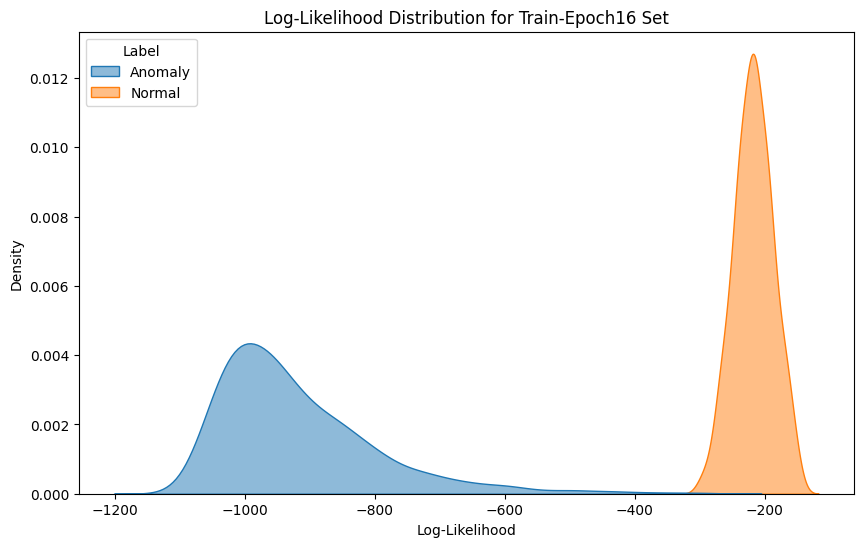

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch16] Mean Normal Log-Likelihood: -193.4764
[Val-Epoch16] Mean Anomaly Log-Likelihood: -792.5298


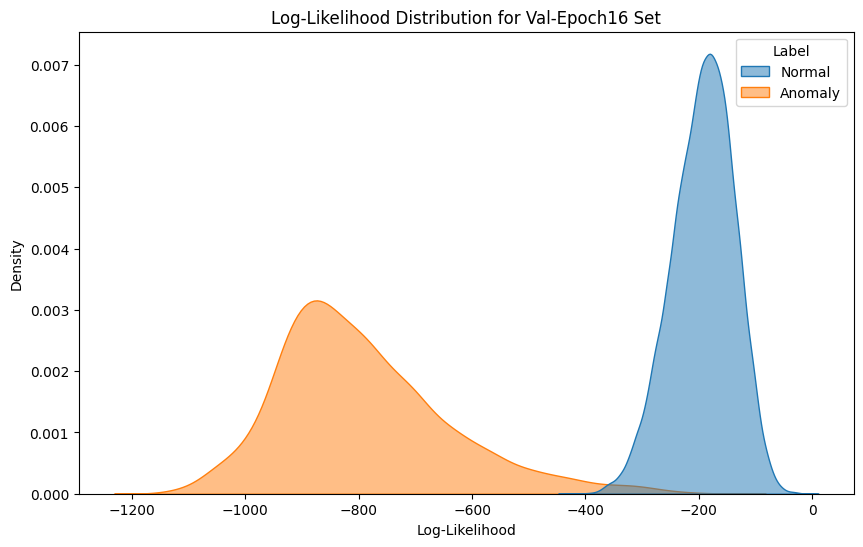

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 208.8336
Contrastive Loss - Anomalous LL Mean: 0.2751
Contrastive Loss - Normal LL Mean: 207.3540
Contrastive Loss - Anomalous LL Mean: 2.0081
Contrastive Loss - Normal LL Mean: 223.5414
Contrastive Loss - Anomalous LL Mean: 0.9768
Contrastive Loss - Normal LL Mean: 224.6468
Contrastive Loss - Anomalous LL Mean: 1.1434
Contrastive Loss - Normal LL Mean: 201.3693
Contrastive Loss - Anomalous LL Mean: 2.8128
Contrastive Loss - Normal LL Mean: 225.0457
Contrastive Loss - Anomalous LL Mean: 3.6970
Contrastive Loss - Normal LL Mean: 207.2239
Contrastive Loss - Anomalous LL Mean: 7.0412
Contrastive Loss - Normal LL Mean: 223.3741
Contrastive Loss - Anomalous LL Mean: 5.4631
Contrastive Loss - Normal LL Mean: 215.8335
Contrastive Loss - Anomalous LL Mean: 1.5987
Contrastive Loss - Normal LL Mean: 225.8369
Contrastive Loss - Anomalous LL Mean: 3.1413
Contrastive Loss - Normal LL Mean: 213.8254
Contrastive Loss - Anomalous LL Mean: 0.2262
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 222.1130
Contrastive Loss - Anomalous LL Mean: 2.8605
Contrastive Loss - Normal LL Mean: 213.4181
Contrastive Loss - Anomalous LL Mean: 1.7676
Contrastive Loss - Normal LL Mean: 211.6630
Contrastive Loss - Anomalous LL Mean: 3.1654
Contrastive Loss - Normal LL Mean: 225.4378
Contrastive Loss - Anomalous LL Mean: 0.5461
Contrastive Loss - Normal LL Mean: 220.2251
Contrastive Loss - Anomalous LL Mean: 1.6832
Contrastive Loss - Normal LL Mean: 227.7929
Contrastive Loss - Anomalous LL Mean: 5.9463
Contrastive Loss - Normal LL Mean: 218.0999
Contrastive Loss - Anomalous LL Mean: 0.8103
Contrastive Loss - Normal LL Mean: 207.4137
Contrastive Loss - Anomalous LL Mean: 4.0611
Contrastive Loss - Normal LL Mean: 185.2049
Contrastive Loss - Anomalous LL Mean: 3.5642
Contrastive Loss - Normal LL Mean: 211.2531
Contrastive Loss - Anomalous LL Mean: 4.9445
Contrastive Loss - Normal LL Mean: 213.7365
Contrastive Loss - Anomalous LL Mean: 0.9324
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch18] Mean Normal Log-Likelihood: -214.6083
[Train-Epoch18] Mean Anomaly Log-Likelihood: -938.7620


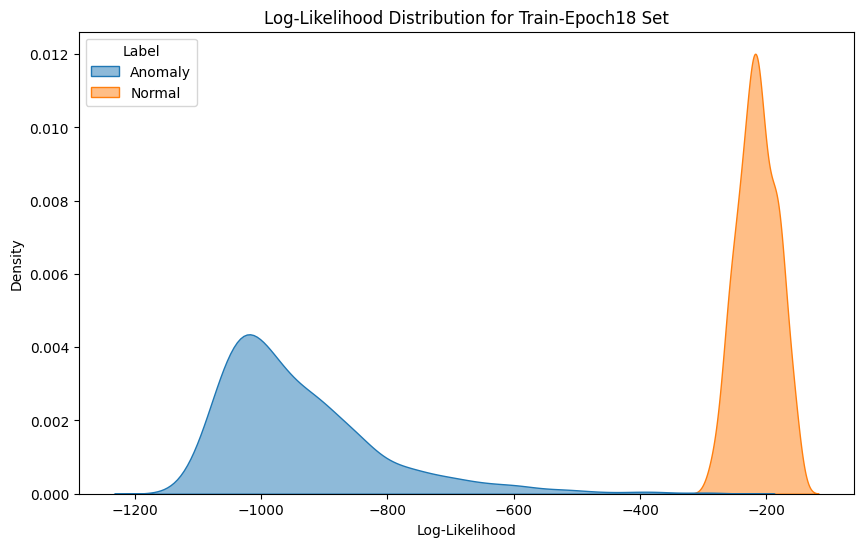

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch18] Mean Normal Log-Likelihood: -191.4515
[Val-Epoch18] Mean Anomaly Log-Likelihood: -815.2348


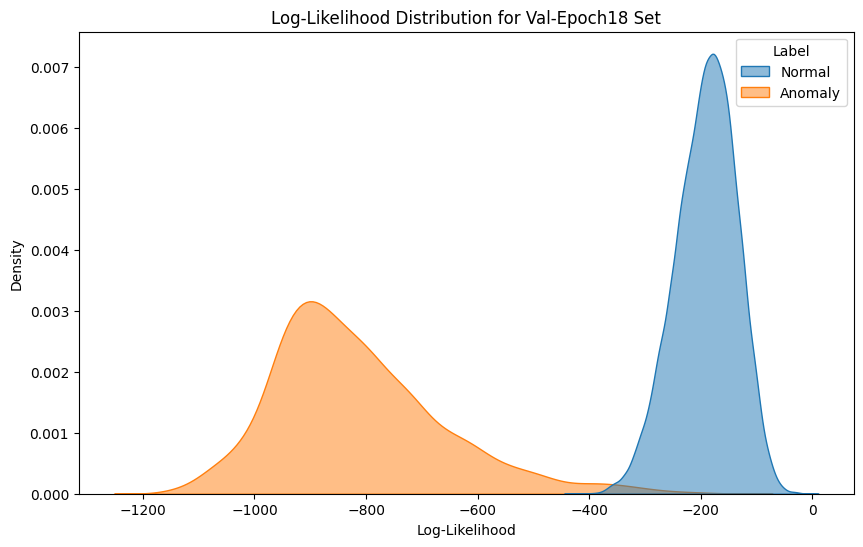

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 226.3333
Contrastive Loss - Anomalous LL Mean: 1.1616
Contrastive Loss - Normal LL Mean: 221.6376
Contrastive Loss - Anomalous LL Mean: 2.1209
Contrastive Loss - Normal LL Mean: 221.9408
Contrastive Loss - Anomalous LL Mean: 1.7700
Contrastive Loss - Normal LL Mean: 205.7471
Contrastive Loss - Anomalous LL Mean: 2.1089
Contrastive Loss - Normal LL Mean: 225.6503
Contrastive Loss - Anomalous LL Mean: 1.1856
Contrastive Loss - Normal LL Mean: 231.6160
Contrastive Loss - Anomalous LL Mean: 1.2973
Contrastive Loss - Normal LL Mean: 236.4857
Contrastive Loss - Anomalous LL Mean: 0.6576
Contrastive Loss - Normal LL Mean: 208.0048
Contrastive Loss - Anomalous LL Mean: 0.0995
Contrastive Loss - Normal LL Mean: 209.7479
Contrastive Loss - Anomalous LL Mean: 1.1920
Contrastive Loss - Normal LL Mean: 230.7648
Contrastive Loss - Anomalous LL Mean: 0.9813
Contrastive Loss - Normal LL Mean: 211.6840
Contrastive Loss - Anomalous LL Mean: 1.3945
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 211.5295
Contrastive Loss - Anomalous LL Mean: 2.6234
Contrastive Loss - Normal LL Mean: 208.9463
Contrastive Loss - Anomalous LL Mean: 1.2148
Contrastive Loss - Normal LL Mean: 206.3402
Contrastive Loss - Anomalous LL Mean: 2.8905
Contrastive Loss - Normal LL Mean: 218.5724
Contrastive Loss - Anomalous LL Mean: 1.4552
Contrastive Loss - Normal LL Mean: 197.8233
Contrastive Loss - Anomalous LL Mean: 3.6897
Contrastive Loss - Normal LL Mean: 207.2887
Contrastive Loss - Anomalous LL Mean: 2.0771
Contrastive Loss - Normal LL Mean: 218.2576
Contrastive Loss - Anomalous LL Mean: 2.3971
Contrastive Loss - Normal LL Mean: 207.1389
Contrastive Loss - Anomalous LL Mean: 3.5304
Contrastive Loss - Normal LL Mean: 215.4881
Contrastive Loss - Anomalous LL Mean: 2.0952
Contrastive Loss - Normal LL Mean: 218.7124
Contrastive Loss - Anomalous LL Mean: 3.5680
Contrastive Loss - Normal LL Mean: 193.1574
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch20] Mean Normal Log-Likelihood: -210.6097
[Train-Epoch20] Mean Anomaly Log-Likelihood: -956.8907


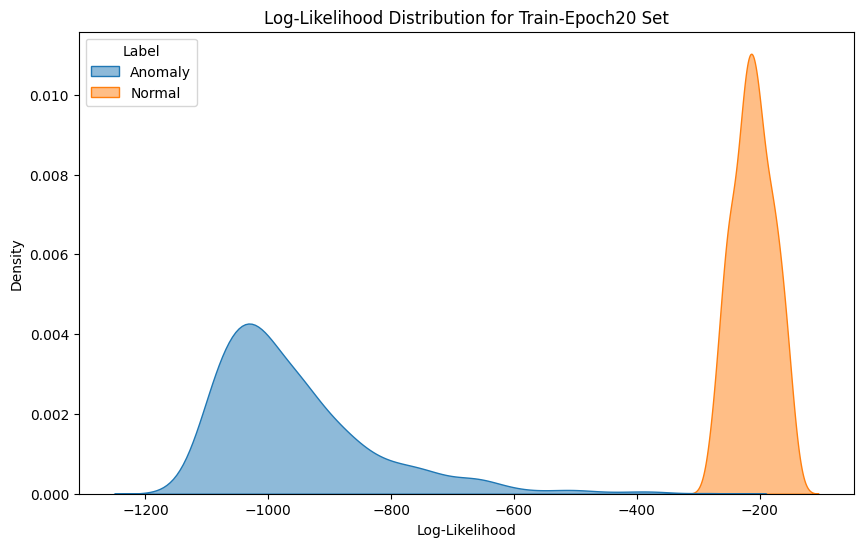

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch20] Mean Normal Log-Likelihood: -189.5718
[Val-Epoch20] Mean Anomaly Log-Likelihood: -837.3622


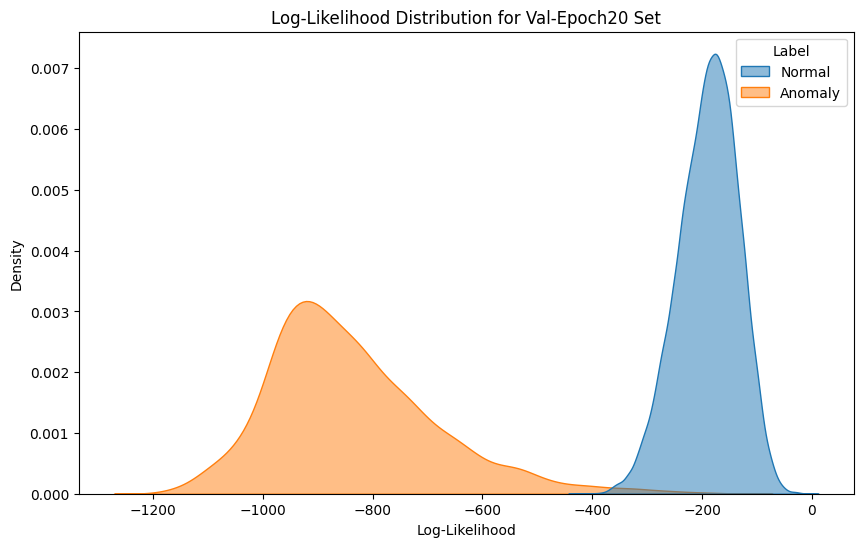

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 227.1844
Contrastive Loss - Anomalous LL Mean: 1.6385
Contrastive Loss - Normal LL Mean: 204.2871
Contrastive Loss - Anomalous LL Mean: 0.3795
Contrastive Loss - Normal LL Mean: 216.6814
Contrastive Loss - Anomalous LL Mean: 3.5907
Contrastive Loss - Normal LL Mean: 215.6461
Contrastive Loss - Anomalous LL Mean: 1.3925
Contrastive Loss - Normal LL Mean: 207.3785
Contrastive Loss - Anomalous LL Mean: 2.1978
Contrastive Loss - Normal LL Mean: 205.3467
Contrastive Loss - Anomalous LL Mean: 0.4761
Contrastive Loss - Normal LL Mean: 197.5232
Contrastive Loss - Anomalous LL Mean: 1.0670
Contrastive Loss - Normal LL Mean: 203.0855
Contrastive Loss - Anomalous LL Mean: 1.9872
Contrastive Loss - Normal LL Mean: 208.1895
Contrastive Loss - Anomalous LL Mean: 7.3362
Contrastive Loss - Normal LL Mean: 213.7871
Contrastive Loss - Anomalous LL Mean: 3.7227
Contrastive Loss - Normal LL Mean: 227.1440
Contrastive Loss - Anomalous LL Mean: 1.8956
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 221.9769
Contrastive Loss - Anomalous LL Mean: 2.5620
Contrastive Loss - Normal LL Mean: 210.6209
Contrastive Loss - Anomalous LL Mean: 0.7750
Contrastive Loss - Normal LL Mean: 195.9565
Contrastive Loss - Anomalous LL Mean: 1.6226
Contrastive Loss - Normal LL Mean: 216.0997
Contrastive Loss - Anomalous LL Mean: 0.9601
Contrastive Loss - Normal LL Mean: 207.6076
Contrastive Loss - Anomalous LL Mean: 0.6217
Contrastive Loss - Normal LL Mean: 224.4984
Contrastive Loss - Anomalous LL Mean: 1.7623
Contrastive Loss - Normal LL Mean: 205.8959
Contrastive Loss - Anomalous LL Mean: 1.2197
Contrastive Loss - Normal LL Mean: 206.4855
Contrastive Loss - Anomalous LL Mean: 4.6423
Contrastive Loss - Normal LL Mean: 201.2987
Contrastive Loss - Anomalous LL Mean: 3.0489
Contrastive Loss - Normal LL Mean: 179.5076
Contrastive Loss - Anomalous LL Mean: 1.0899
Contrastive Loss - Normal LL Mean: 208.1912
Contrastive Loss - Anomalous LL Mean: 0.8994
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch22] Mean Normal Log-Likelihood: -207.5436
[Train-Epoch22] Mean Anomaly Log-Likelihood: -982.5810


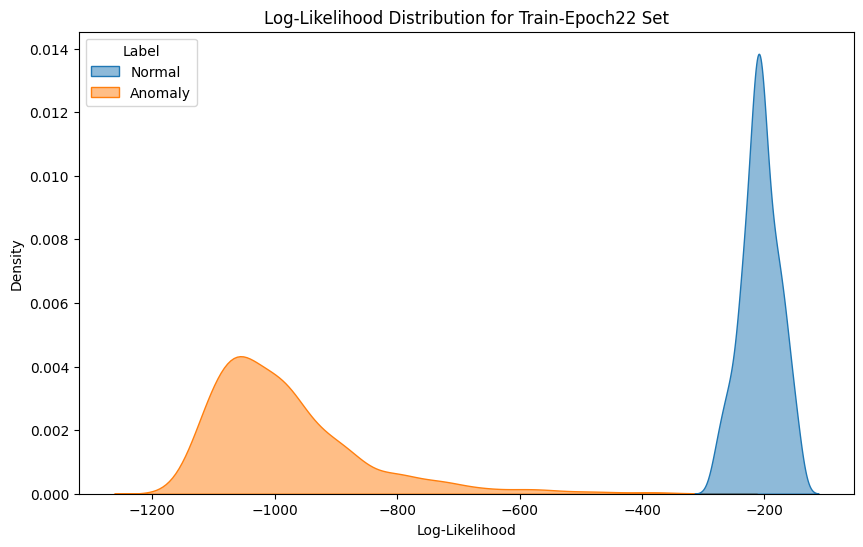

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch22] Mean Normal Log-Likelihood: -187.7337
[Val-Epoch22] Mean Anomaly Log-Likelihood: -859.6613


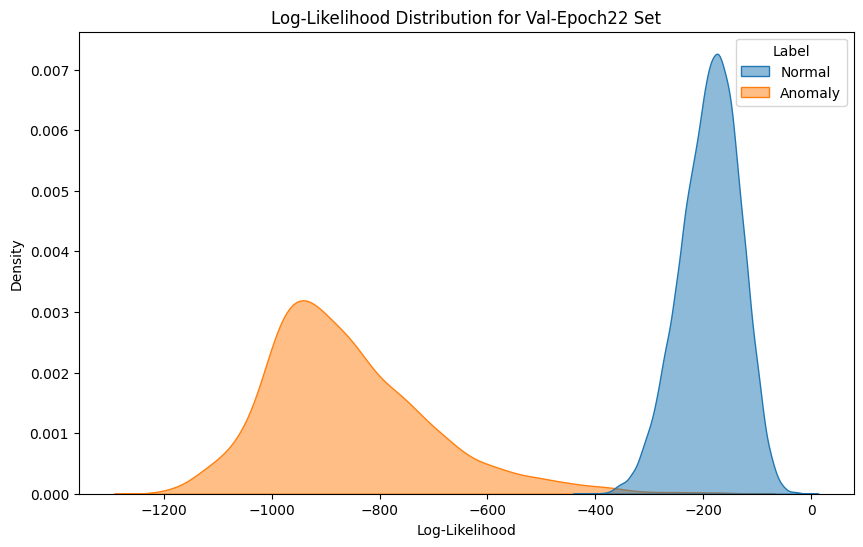

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 209.2786
Contrastive Loss - Anomalous LL Mean: 0.8408
Contrastive Loss - Normal LL Mean: 242.9085
Contrastive Loss - Anomalous LL Mean: 2.6958
Contrastive Loss - Normal LL Mean: 213.0056
Contrastive Loss - Anomalous LL Mean: 0.3053
Contrastive Loss - Normal LL Mean: 188.8881
Contrastive Loss - Anomalous LL Mean: 1.5080
Contrastive Loss - Normal LL Mean: 204.9867
Contrastive Loss - Anomalous LL Mean: 0.9858
Contrastive Loss - Normal LL Mean: 231.7705
Contrastive Loss - Anomalous LL Mean: 2.1338
Contrastive Loss - Normal LL Mean: 202.1405
Contrastive Loss - Anomalous LL Mean: 1.5492
Contrastive Loss - Normal LL Mean: 202.7779
Contrastive Loss - Anomalous LL Mean: 3.4909
Contrastive Loss - Normal LL Mean: 227.7920
Contrastive Loss - Anomalous LL Mean: 0.7723
Contrastive Loss - Normal LL Mean: 200.4213
Contrastive Loss - Anomalous LL Mean: 1.0442
Contrastive Loss - Normal LL Mean: 205.2868
Contrastive Loss - Anomalous LL Mean: 1.5923
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 201.8609
Contrastive Loss - Anomalous LL Mean: 4.2898
Contrastive Loss - Normal LL Mean: 240.3113
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 195.3909
Contrastive Loss - Anomalous LL Mean: 0.7622
Contrastive Loss - Normal LL Mean: 194.0552
Contrastive Loss - Anomalous LL Mean: 0.6908
Contrastive Loss - Normal LL Mean: 207.7478
Contrastive Loss - Anomalous LL Mean: 0.9937
Contrastive Loss - Normal LL Mean: 218.5867
Contrastive Loss - Anomalous LL Mean: 0.3084
Contrastive Loss - Normal LL Mean: 214.0507
Contrastive Loss - Anomalous LL Mean: 1.1092
Contrastive Loss - Normal LL Mean: 193.8349
Contrastive Loss - Anomalous LL Mean: 2.6448
Contrastive Loss - Normal LL Mean: 186.8288
Contrastive Loss - Anomalous LL Mean: 0.8101
Contrastive Loss - Normal LL Mean: 201.2906
Contrastive Loss - Anomalous LL Mean: 2.0118
Contrastive Loss - Normal LL Mean: 212.0557
Contrastive Loss - Anomalous LL Mean: 1.0009
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Epoch24] Mean Normal Log-Likelihood: -202.9793
[Train-Epoch24] Mean Anomaly Log-Likelihood: -994.5538


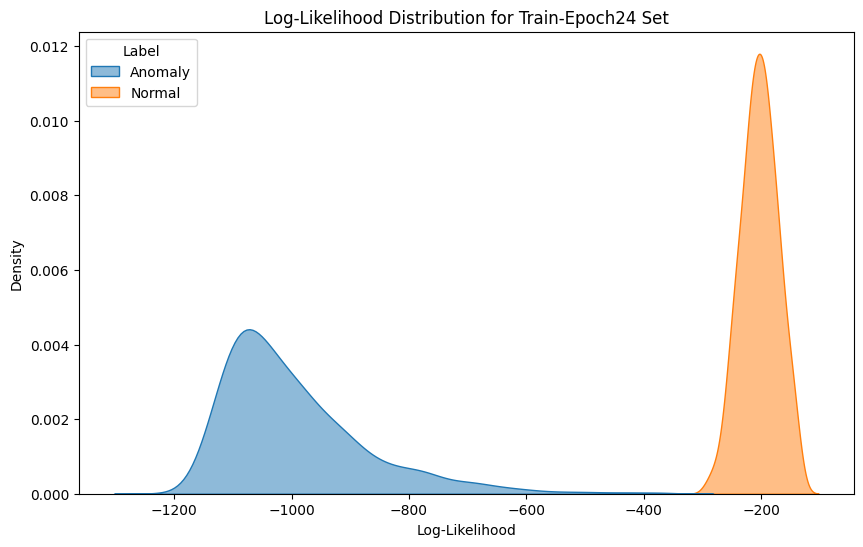

Validation set separation:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Epoch24] Mean Normal Log-Likelihood: -185.8394
[Val-Epoch24] Mean Anomaly Log-Likelihood: -870.0627


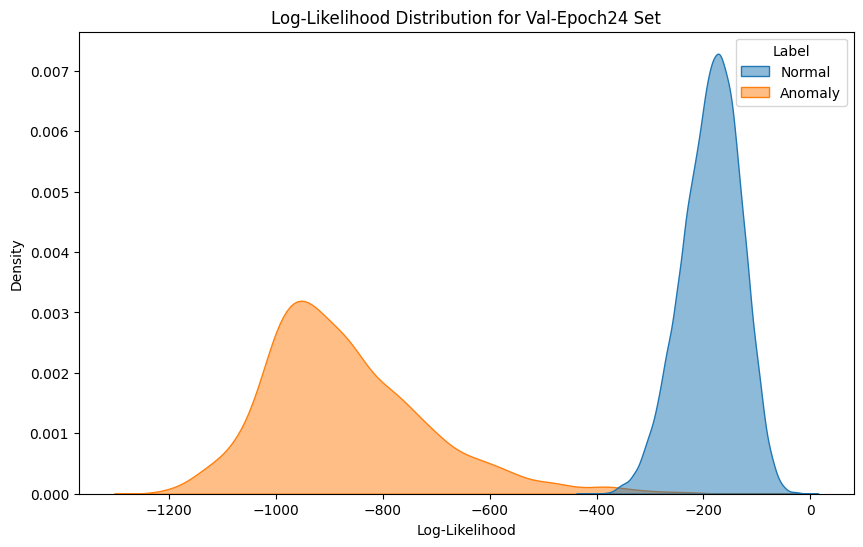

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Contrastive Loss - Normal LL Mean: 225.1774
Contrastive Loss - Anomalous LL Mean: 2.3921
Contrastive Loss - Normal LL Mean: 201.5189
Contrastive Loss - Anomalous LL Mean: 0.8308
Contrastive Loss - Normal LL Mean: 216.0770
Contrastive Loss - Anomalous LL Mean: 2.0732
Contrastive Loss - Normal LL Mean: 201.2059
Contrastive Loss - Anomalous LL Mean: 1.7131
Contrastive Loss - Normal LL Mean: 206.5583
Contrastive Loss - Anomalous LL Mean: 3.3118
Contrastive Loss - Normal LL Mean: 189.1767
Contrastive Loss - Anomalous LL Mean: 0.0821
Contrastive Loss - Normal LL Mean: 220.5859
Contrastive Loss - Anomalous LL Mean: 2.3621
Contrastive Loss - Normal LL Mean: 213.4271
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 198.1387
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 195.6020
Contrastive Loss - Anomalous LL Mean: 0.0000
Contrastive Loss - Normal LL Mean: 200.0991
Contrastive Loss - Anomalous LL Mean: 2.5381
Contrastive Loss - No

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Train-Final] Mean Normal Log-Likelihood: -204.1573
[Train-Final] Mean Anomaly Log-Likelihood: -999.6877


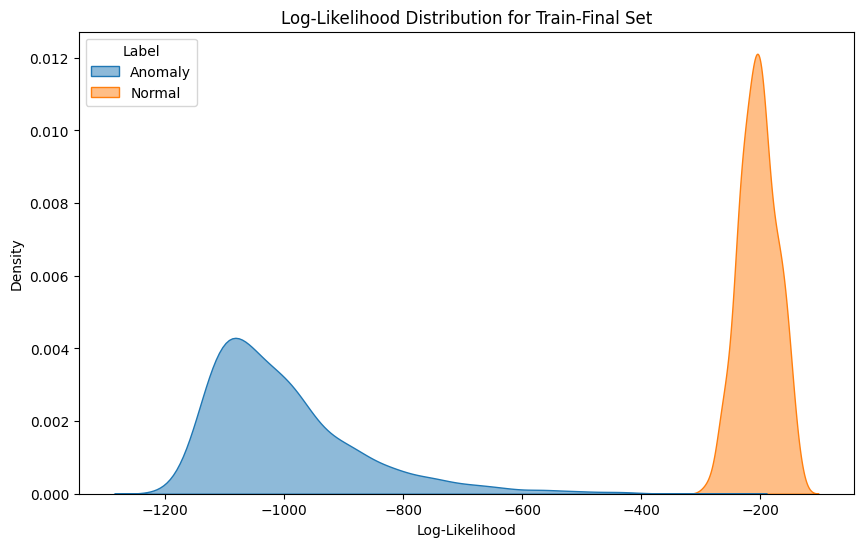


--- Final Evaluate on Validation Set ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val-Final] Mean Normal Log-Likelihood: -184.9133
[Val-Final] Mean Anomaly Log-Likelihood: -877.8047


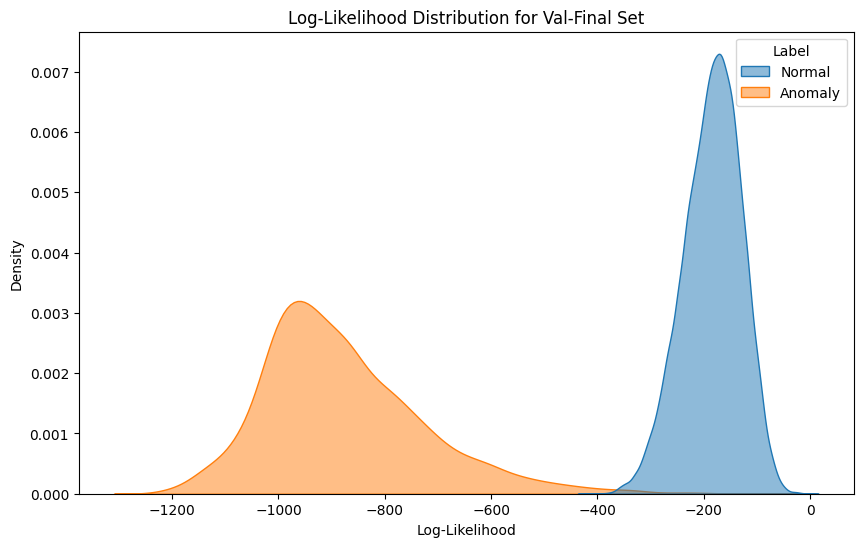


--- Reloaded Model: Evaluate on Training ---


<ipython-input-27-851dedf67d3b>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load('model_final.pth'), strict=True)
/usr/local/lib/py

[Train Reloaded] Mean Normal Log-Likelihood: -201.7820
[Train Reloaded] Mean Anomaly Log-Likelihood: -1001.5783


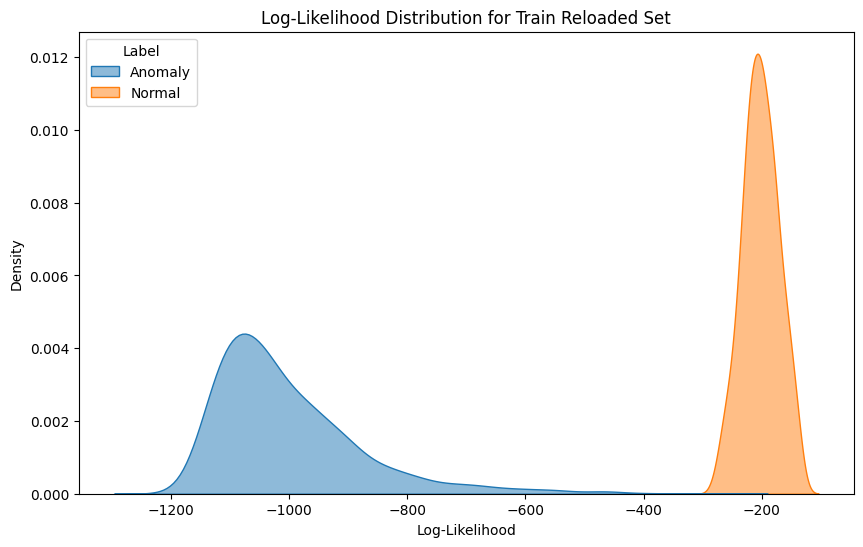


--- Reloaded Model: Evaluate on Validation ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Val Reloaded] Mean Normal Log-Likelihood: -184.9133
[Val Reloaded] Mean Anomaly Log-Likelihood: -877.8047


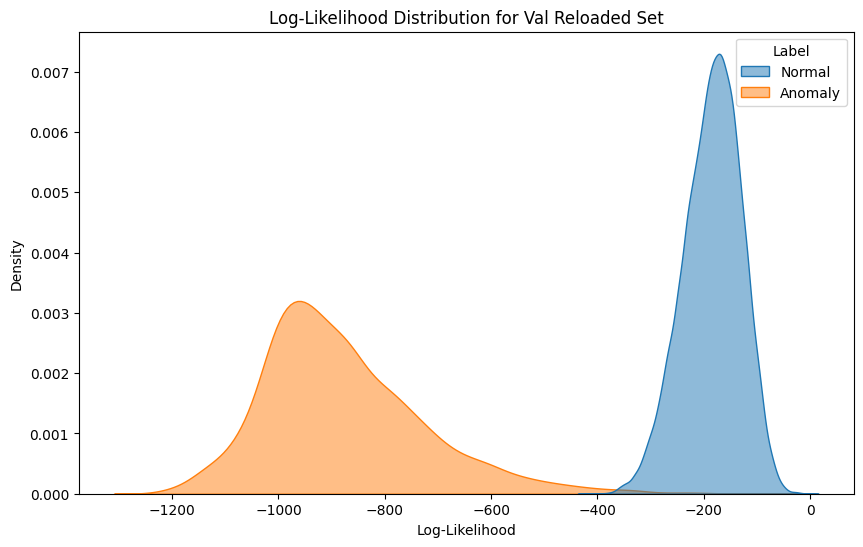

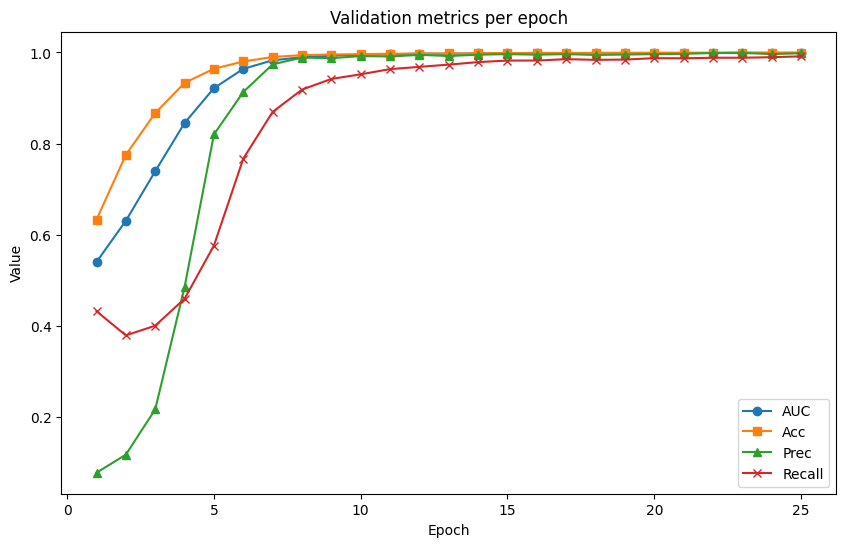

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_epochs = 25
epoch_losses = []
val_metrics_history = []

# Arrays to store metrics each epoch
auc_roc_values   = []
accuracy_values  = []
precision_values = []
recall_values    = []

# (If needed) define your LR scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

best_f1           = 0.0
patience_counter  = 0
patience          = 10

try:
    for epoch in range(num_epochs):
        ################################################
        # 1) TRAIN
        ################################################
        model.train()
        running_loss = 0.0

        for batch_idx, (padded_x1, padded_x2, labels, x1_mask, x2_mask) in enumerate(train_loader):
            padded_x1 = padded_x1.to(device)
            padded_x2 = padded_x2.to(device)
            labels    = labels.to(device)
            x1_mask   = x1_mask.to(device)
            x2_mask   = x2_mask.to(device)

            optimizer.zero_grad()

            # If your model returns (ll_gaussian, ll_vine), you might unify them,
            # but for now let's keep your existing logic:
            ll_gaussian, ll_vine = model(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            loss = contrastive_loss(ll_gaussian, ll_vine, labels, alpha=0.3, base_margin=500.0)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

        ################################################
        # 2) VALIDATE AFTER EVERY EPOCH
        ################################################
        val_metrics = validate(model, val_loader, device)
        print(f"Validation Metrics @ Epoch {epoch+1}: {val_metrics}")

        # Collect metrics
        auc_roc_values.append(val_metrics['auc_roc'])
        accuracy_values.append(val_metrics['accuracy'])
        precision_values.append(val_metrics['precision'])
        recall_values.append(val_metrics['recall'])

        # Example LR-scheduler usage (comment out if you don't need it)
        # scheduler.step(val_metrics['auc_roc'])

        ################################################
        # 3) PLOT LIKELIHOOD SEPARATION
        #    - Once at start: epoch == 0
        #    - Then every 2 epochs => (epoch+1)%2==0 => 2,4,6...
        ################################################
        if epoch == 0:
            print("\n>>> Plotting Log-Likelihoods at the start (Epoch 1) <<<")
            print("Training set separation:")
            plot_log_likelihoods(model, train_loader, device, dataset_name="Train-Epoch1")
            print("Validation set separation:")
            plot_log_likelihoods(model, val_loader, device, dataset_name="Val-Epoch1")

        elif (epoch + 1) % 2 == 0:
            print(f"\n>>> Plotting Log-Likelihoods after {epoch+1} epochs <<<")
            print("Training set separation:")
            plot_log_likelihoods(model, train_loader, device,
                                 dataset_name=f"Train-Epoch{epoch+1}")
            print("Validation set separation:")
            plot_log_likelihoods(model, val_loader, device,
                                 dataset_name=f"Val-Epoch{epoch+1}")

except KeyboardInterrupt:
    print("Training interrupted. Saving model...")

# After training, finalize, e.g.:
print("\n--- Final Evaluate on Training Set ---")
plot_log_likelihoods(model, train_loader, device, dataset_name="Train-Final")

print("\n--- Final Evaluate on Validation Set ---")
plot_log_likelihoods(model, val_loader, device, dataset_name="Val-Final")

# Save your model
torch.save(model.state_dict(), 'model_final.pth')

# Optionally reload, check
model_loaded = AnomalyTransformer(input_dim=input_dim,
                                  model_dim=model_dim,
                                  num_heads=num_heads,
                                  num_layers=num_layers,
                                  dropout=dropout).to(device)
model_loaded.load_state_dict(torch.load('model_final.pth'), strict=True)
model_loaded.eval()

print("\n--- Reloaded Model: Evaluate on Training ---")
plot_log_likelihoods(model_loaded, train_loader, device, dataset_name="Train Reloaded")

print("\n--- Reloaded Model: Evaluate on Validation ---")
plot_log_likelihoods(model_loaded, val_loader, device, dataset_name="Val Reloaded")

# If you want to plot your metrics:
import matplotlib.pyplot as plt
import numpy as np

epochs_array = np.arange(1, num_epochs+1)

plt.figure(figsize=(10,6))
plt.plot(epochs_array, auc_roc_values,    label="AUC",   marker='o')
plt.plot(epochs_array, accuracy_values,   label="Acc",   marker='s')
plt.plot(epochs_array, precision_values,  label="Prec",  marker='^')
plt.plot(epochs_array, recall_values,     label="Recall",marker='x')
plt.legend()
plt.title("Validation metrics per epoch")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()


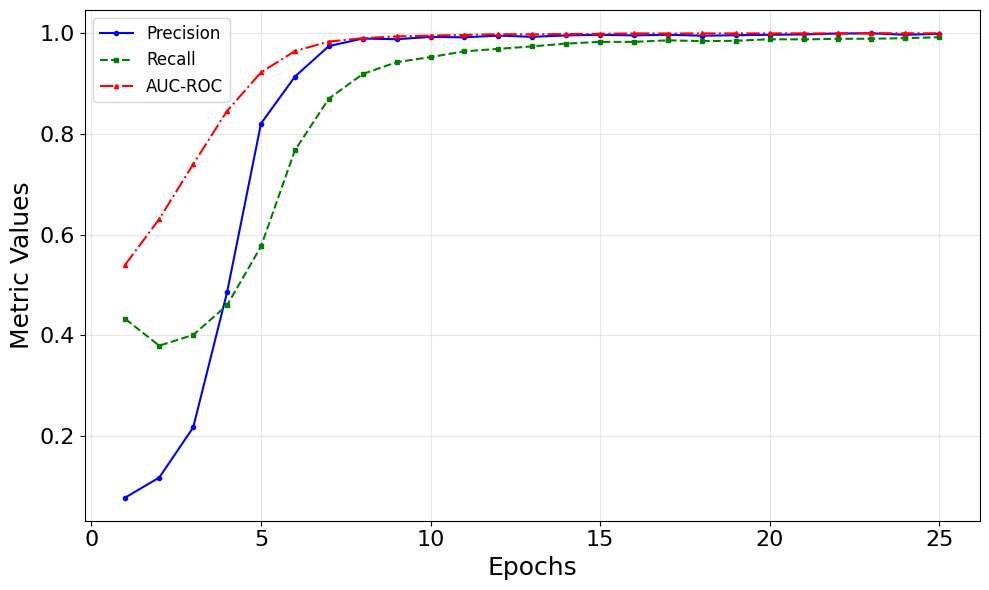

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for precision, recall, and AUC-ROC (replace these with your actual values)
epochs = np.arange(1, 26)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision_values, label='Precision', color='blue', marker='o', markersize=3, linestyle='-')
plt.plot(epochs, recall_values, label='Recall', color='green', marker='s', markersize=3, linestyle='--')
plt.plot(epochs, auc_roc_values, label='AUC-ROC', color='red', marker='^', markersize=3, linestyle='-.')

# Add titles and labels
#plt.title('Performance Metrics Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Metric Values', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(alpha=0.3)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Load the saved state_dict, ignoring missing keys
model.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_anomaly_70_percent_alpha_03.pth'), strict=False)

<ipython-input-70-75698393c95d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_gp_copula_likelihood_loss_margin_500_real_anomaly_70

<All keys matched successfully>

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Training] Mean Normal Log-Likelihood: -202.4971
[Training] Mean Anomaly Log-Likelihood: -1018.3791


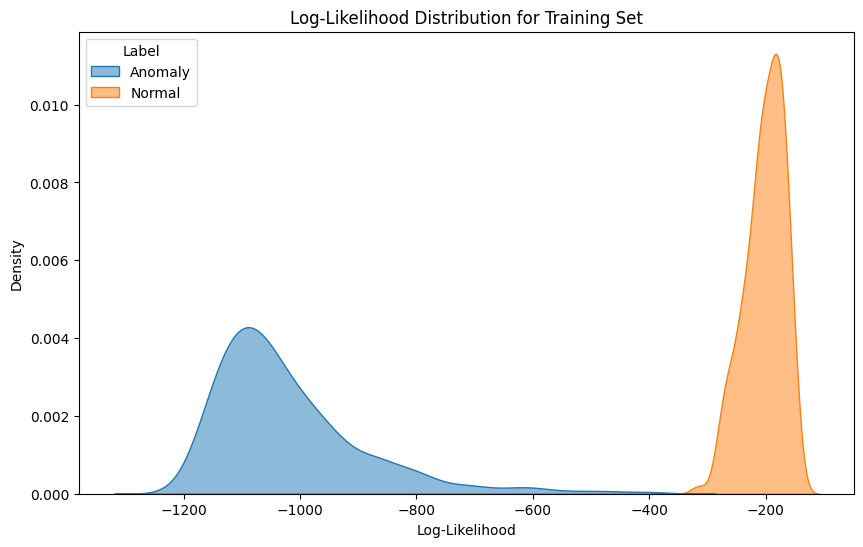

In [ ]:
# Plot for Training Set
plot_log_likelihoods(model, train_loader, device, dataset_name="Training")

# Plot for Validation Set
#plot_log_likelihoods(model, val_loader, device, dataset_name="Validation")


In [ ]:
# Plot for Validation Set
plot_log_likelihoods(model, val_loader, device, dataset_name="Validation")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Test] Mean Normal Log-Likelihood: -179.5364
[Test] Mean Anomaly Log-Likelihood: -898.2218


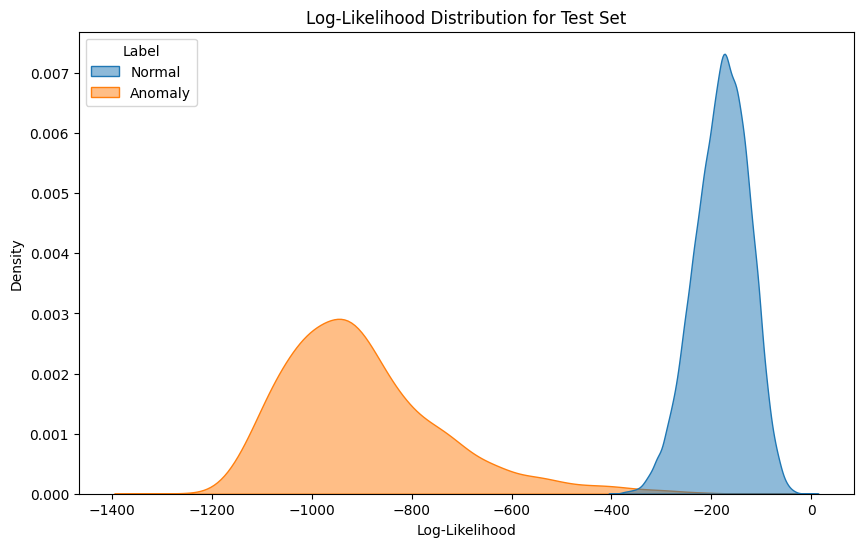

In [ ]:
# Plot for Validation Set
plot_log_likelihoods(model, test_loader, device, dataset_name="Test")

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_latent_space(model, loader, device, dataset_name="Dataset"):
    """
    This function visualizes the latent space by extracting embeddings from the model
    for each batch in 'loader'. We'll handle 3 batch-size scenarios:
      1) 5 items: (x1, x2, labels, x1_mask, x2_mask)
      2) 3 items: (x1, x2, labels)
      3) 2 items: (features, labels)
    We'll assume the model has a method 'get_embeddings(x1, x2, mask1, mask2)'
    that returns an embedding (e.g. shape (batch_size, embed_dim)).
    """

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch

    model.eval()

    all_embeddings = []
    all_labels     = []

    with torch.no_grad():
        for batch in loader:
            if len(batch) == 5:
                # (padded_x1, padded_x2, batch_labels, x1_mask, x2_mask)
                padded_x1, padded_x2, batch_labels, x1_mask, x2_mask = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels = batch_labels.to(device)
                x1_mask = x1_mask.to(device)
                x2_mask = x2_mask.to(device)

                # We'll call some method get_embeddings() if your model has it
                embeddings = model.get_embeddings(padded_x1, padded_x2, mask1=x1_mask, mask2=x2_mask)

            elif len(batch) == 3:
                # (padded_x1, padded_x2, batch_labels)
                padded_x1, padded_x2, batch_labels = batch

                padded_x1 = padded_x1.to(device, dtype=torch.float32)
                padded_x2 = padded_x2.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                embeddings = model.get_embeddings(padded_x1, padded_x2)

            elif len(batch) == 2:
                # (features, labels)
                features, batch_labels = batch

                features = features.to(device, dtype=torch.float32)
                batch_labels= batch_labels.to(device)

                # If model expects two inputs, pass features twice
                # or adapt if your model uses a single input in get_embeddings
                embeddings = model.get_embeddings(features, features)

            else:
                raise ValueError(f"Unexpected number of items in batch: {len(batch)}")

            # Convert embeddings + labels to CPU
            emb_np = embeddings.cpu().numpy()
            lbl_np = batch_labels.cpu().numpy()

            all_embeddings.append(emb_np)
            all_labels.append(lbl_np)

    # Concat all
    all_embeddings = np.concatenate(all_embeddings, axis=0)  # shape (total_samples, embed_dim)
    all_labels     = np.concatenate(all_labels,     axis=0)  # shape (total_samples,)

    # Suppose we do a 2D visualization via e.g. TSNE
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=0)
    emb_2d = tsne.fit_transform(all_embeddings)

    # Plot
    plt.figure(figsize=(8,6))
    # separate normal vs anomaly for coloring
    normal_mask  = (all_labels == 0)
    anomaly_mask = (all_labels == 1)

    plt.scatter(emb_2d[normal_mask,0],  emb_2d[normal_mask,1],  c='blue',  alpha=0.5, label='Normal')
    plt.scatter(emb_2d[anomaly_mask,0], emb_2d[anomaly_mask,1], c='red',   alpha=0.5, label='Anomaly')

    plt.title(f"Latent Space Visualization - {dataset_name}")
    plt.legend()
    plt.show()


<ipython-input-45-23dcfd278168>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('anomaly_detection_model_08_per_min_max.pth'), strict=Fals

FileNotFoundError: [Errno 2] No such file or directory: 'anomaly_detection_model_08_per_min_max.pth'

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


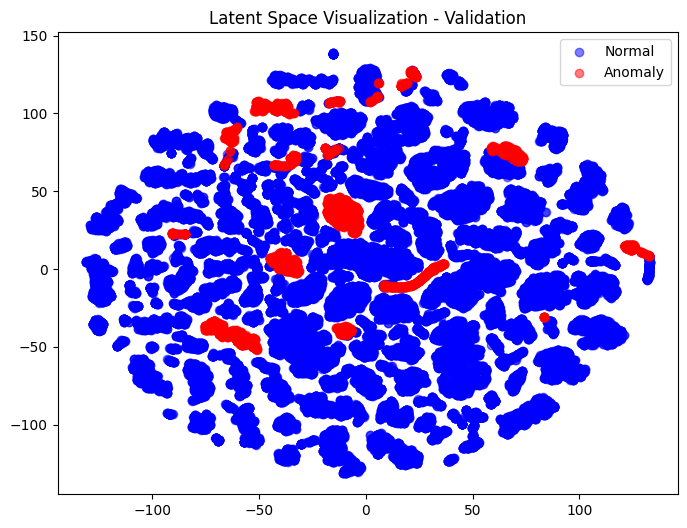

In [ ]:
# Visualize the latent space for the training set
#visualize_latent_space(model, train_loader, device, dataset_name="Train")

# Visualize the latent space for the test set
visualize_latent_space(model, val_loader, device, dataset_name="Validation")
